# RTcotomy ML

## Load Python Packages

In [183]:
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Define data filepaths, codes, dictionaries and common columns

In [184]:
data_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/Data/Raw_data/PUF AY %i/CSV/'
years = range(2017, 2023)
thoracotomy_codes = ['0WJB0ZZ', '0WJ90ZZ', '02JA0ZZ', '02JY0ZZ', '0BJL0ZZ', '0BJK0ZZ', '0BJQ0ZZ','0WJ80ZZ', '0WJC0ZZ', '0WJD0ZZ', '02VW0CZ', '02QA0ZZ', '3E080GC']
sternotomy_codes = ['0P800ZZ']

mechanism_code_dict = {1:'Cut/pierce', 2:'Drowning/submersion', 3:'Fall', 4:'Fire/flame', 5:'Hot object/substance', 6:'Firearm', 7:'Machinery', 8:'MVT Occupant', 9:'MVT Motorcyclist', 10:'MVT Pedal cyclist', 11:'MVT Pedestrian', 12:'MVT Unspecified', 13:'MVT Other', 14:'Pedal cyclist, other', 15:'Pedestrian, other', 16:'Transport, other', 17:'Natural/environmental,  Bites and stings', 18:'Natural/environmental,  Other', 19:'Overexertion', 20:'Poisoning', 21:'Struck by, against', 22:'Suffocation', 23:'Other specified and classifiable', 24:'Other specified, not elsewhere classifiable', 25:'Unspecified', 26:'Adverse effects, medical care', 27:'Adverse effects, drugs'} # As noted in PUF dictionary
trauma_type_code_dict = {1:'Blunt', 2:'Penetrating', 3:'Burn', 4:'Other/unspecified', 9:'Activity Code - Not Valid as a Primary E-Code'} # As noted in PUF Dictionary
sex_code_dict = {1:'Male', 2:'Female', 3:'Unknown'}
eddischarge_code_dict = {1: 'Floor bed (general admission, non-specialty unit bed)', 2: 'Observation unit (unit that provides < 24 hour stays)', 3: 'Telemetry/step-down unit (less acuity than ICU)', 4: 'Home with services', 5: 'Deceased/expired', 6: 'Other (jail, institutional care, mental health, etc.)', 7: 'Operating Room', 8: 'Intensive Care Unit (ICU)', 9: 'Home without services', 10: 'Left against medical advice', 11: 'Transferred to another hospital'}
hospdischarge_disposition_code_dict = {1: 'Discharged/Transferred to a short-term general hospital for inpatient care', 2: 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 3: 'Discharged/Transferred to home under care of organized home health service', 4: 'Left against medical advice or discontinued care', 5: 'Deceased/Expired', 6: 'Discharged to home or self-care (routine discharge)', 7: 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 8: 'Discharged/Transferred to hospice care', 10: 'Discharged/Transferred to court/law enforcement', 11: 'Discharged/Transferred to inpatient rehab or designated unit', 12: 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 13: 'Discharged/Transferred to a psychiatric hospital or psychiatric distinct part unit of a hospital', 14: 'Discharged/Transferred to another type of institution not defined elsewhere'}
deathined_code_dict = {1:'Arrived with NO signs of life', 2:'Arrived with signs of life'}
prehospca_code_dict = {1:'Yes', 2:'No'}
transport_mode_code_dict = {1:'Ground Ambulance', 2:'Helicopter Ambulance', 3:'Fixed-wing Ambulance', 4:'Private/Public Vehicle/Walk-in', 5:'Police', 6:'Other'}

cols17 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols19 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols17 = [x.upper() for x in cols17]
cols19 = [x.upper() for x in cols19]

common_cols = list(set(cols17) & set(cols19))

## Load in data and format by year to create data files for use

In [185]:
for year in years:
    
    if year in range(2017, 2019):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    elif year in range(2019, 2023):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    else:
        pass
    
    TRAUMA_df.columns = map(str.upper, TRAUMA_df.columns)
    ICDPROCEDURE_df.columns = map(str.upper, ICDPROCEDURE_df.columns)
    ICDPROCEDURE_LOOKUP_df.columns = map(str.upper, ICDPROCEDURE_LOOKUP_df.columns)
    ECODE_LOOKUP_df.columns = map(str.upper, ECODE_LOOKUP_df.columns)
    
    if year in range(2019, 2023):
        ICDPROCEDURE_df['PROCEDUREMINS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTHRS']*60
        ICDPROCEDURE_df['PROCEDUREDAYS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTDAYS']
        TRAUMA_df['HMRRHGCTRLSURGMINS'] = TRAUMA_df['HMRRHGCTRLSURGHRS']*60
    else:
        pass
    
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[:, ['INC_KEY', 'ICDPROCEDURECODE', 'PROCEDUREMINS', 'PROCEDUREDAYS']]
    
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'HMRRHGCTRLSURGMINS'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['HMRRHGCTRLSURGTYPE'] == 3.0]
    
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[ICDPROCEDURE_df['INC_KEY'].isin(np.unique(TRAUMA_df['INC_KEY']))]
    
    ICDPROCEDURE_LOOKUP_df = ICDPROCEDURE_LOOKUP_df.loc[:, ['ICDPROCEDURECODE', 'ICDPROCEDURECODE_DESC']]
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    ecode_dict = dict(zip(ECODE_LOOKUP_df['ECODE'], ECODE_LOOKUP_df['ECODE_DESC'])) # create dictionary
    TRAUMA_df['PRIMARYECODEICD10'] = TRAUMA_df['PRIMARYECODEICD10'].replace(ecode_dict) # implement dictionary
    
    mechanism_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['MECHANISM'])) # create dictionary
    TRAUMA_df['MECHANISM'] = TRAUMA_df['PRIMARYECODEICD10'].map(mechanism_dict) # implement dictionary
    
    traumatype_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['TRAUMATYPE'])) # create dictionary
    TRAUMA_df['TRAUMATYPE'] = TRAUMA_df['PRIMARYECODEICD10'].map(traumatype_dict) # implement dictionary
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'TRAUMATYPE', 'MECHANISM'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['INC_KEY'].isin(np.unique(ICDPROCEDURE_df['INC_KEY']))]
    
    TRAUMA_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLTRAUMA_df_%i.csv'%year, index=False)
    ICDPROCEDURE_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLICDPROCEDURE_df_%i.csv'%year, index=False)
    
    display(ICDPROCEDURE_df.head())
    display(TRAUMA_df.head())
    
    # Free up memory
    del TRAUMA_df, ICDPROCEDURE_df, ICDPROCEDURE_LOOKUP_df, ECODE_LOOKUP_df

INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
1050  170002937445          0BH17EZ            8.0            1.0
4010  170000021215          0W9930Z            NaN            NaN
4011  170000021215          0W9B30Z            NaN            NaN
4012  170000021215          0Y950ZZ            NaN            NaN
4013  170000021215          5A1221Z            NaN            NaN

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
251                  NaN                     1.0          2.0   
835                  NaN                     1.0          2.0   
1412                 NaN                     1.0          2.0   
1489                 NaN                     1.0          2.0   
1825                 NaN                     1.0          2.0   

      ABUSEREPORT_BIU ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
251               NaN                  NaN                       1.0   
835               NaN                  NaN                       1.0   
1412              NaN                  NaN                       1.0   
1489              NaN             W74.XXXA                       NaN   
1825              NaN                  NaN                       1.0   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
251       33.0                     0                   0   
835       24.0                     0                   1   
1412      31.0                     0                   1   
1489      24.0                     0                   1   
1825      24.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
251                       0  ...   103.0         NaN      0            2.0   
835                       0  ...    91.0         NaN      0            2.0   
1412                      0  ...    59.0         NaN      0            2.0   
1489                      0  ...    70.0         NaN      0            NaN   
1825                      0  ...   100.0         NaN      0            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
251                 NaN                NaN                NaN          2.0   
835                 NaN                NaN                NaN          2.0   
1412                NaN                NaN                NaN          2.0   
1489                NaN                NaN                2.0          2.0   
1825                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
251               NaN   2017.0  
835               NaN   2017.0  
1412              NaN   2017.0  
1489              NaN   2017.0  
1825              NaN   2017.0  

[5 rows x 332 columns]

INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
2363  180023610118          BW40ZZZ            0.0            1.0
2364  180023610118          0BH17EZ            6.0            1.0
2366  180023610118          0W9930Z           10.0            1.0
2367  180023610118          0WJ90ZZ           29.0            1.0
2368  180023610118          02QA0ZZ           29.0            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
301                  NaN                     1.0          2.0   
1819                 NaN                     1.0          2.0   
2118                 NaN                     1.0          2.0   
3020                 NaN                     1.0          2.0   
3257                 NaN                     1.0          2.0   

      ABUSEREPORT_BIU ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
301               NaN                  NaN                       1.0   
1819              NaN               Y07.04                       NaN   
2118              NaN                  NaN                       1.0   
3020              NaN                  NaN                       1.0   
3257              NaN                  NaN                       1.0   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
301       20.0                     0                   1   
1819      27.0                     0                   1   
2118      35.0                     0                   1   
3020      22.0                     0                   1   
3257      71.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
301                       0  ...   123.0         NaN      1            2.0   
1819                      0  ...    86.0         NaN      0            2.0   
2118                      0  ...     NaN         2.0      0            2.0   
3020                      0  ...    73.0         NaN      1            2.0   
3257                      0  ...     NaN         2.0      1            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
301                 NaN                NaN                NaN          2.0   
1819                NaN                NaN                NaN          2.0   
2118                NaN                NaN                NaN          2.0   
3020                NaN                NaN                NaN          2.0   
3257                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
301               NaN   2018.0  
1819              NaN   2018.0  
2118              NaN   2018.0  
3020              NaN      NaN  
3257              NaN      NaN  

[5 rows x 332 columns]

INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
1181  190027760890          BW03ZZZ            1.8            1.0
1309  190027760890          BN25ZZZ           24.0            1.0
1311  190027760890          BW40ZZZ            4.2            1.0
1313  190027760890          03HB33Z           49.8            1.0
1316  190027760890          0W9930Z           64.8            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
156                  NaN                     1.0          2.0   
173                  NaN                     1.0          2.0   
192                  NaN                     1.0          2.0   
1042                 NaN                     1.0          2.0   
3316                 NaN                     1.0          2.0   

      ABUSEREPORT_BIU ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
156               NaN                  NaN                       1.0   
173               NaN                  NaN                       1.0   
192               NaN                  NaN                       1.0   
1042              NaN                  NaN                       1.0   
3316              NaN                  NaN                       1.0   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
156       21.0                     0                   1   
173       29.0                     0                   1   
192       60.0                     0                   1   
1042      21.0                     0                   1   
3316      26.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
156                       0  ...     NaN         2.0      0            2.0   
173                       0  ...    81.7         NaN      0            2.0   
192                       0  ...     NaN         2.0      0            2.0   
1042                      0  ...    73.4         NaN      1            2.0   
3316                      0  ...    92.0         NaN      0            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
156                 NaN                NaN                NaN          2.0   
173                 NaN                NaN                NaN          2.0   
192                 NaN                NaN                NaN          2.0   
1042                NaN                NaN                NaN          2.0   
3316                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
156               NaN      NaN  
173               NaN      NaN  
192               NaN      NaN  
1042              NaN      NaN  
3316              NaN      NaN  

[5 rows x 332 columns]

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
2551   200042924891              NaN            NaN            NaN
10107  200043189429          03HY32Z           22.2            1.0
10108  200043189429          05H533Z         1561.2            2.0
10109  200043189429          0BBL0ZZ          343.8            1.0
10110  200043189429          0BH17EZ          142.8            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
504                  NaN                     NaN          NaN   
1459                 NaN                     NaN          NaN   
2010                 NaN                     NaN          NaN   
3111                 NaN                     NaN          NaN   
3214                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
504               NaN                   NaN                       NaN   
1459              NaN                   NaN                       NaN   
2010              NaN                   NaN                       NaN   
3111              NaN                   NaN                       NaN   
3214              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
504       23.0                     0                   1   
1459      89.0                     1                   0   
2010      26.0                     0                   1   
3111      31.0                     0                   1   
3214      37.0                     0                   0   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
504                       0  ...   100.0         NaN      0            2.0   
1459                      0  ...    80.0         NaN      1            2.0   
2010                      0  ...     NaN         2.0      0            2.0   
3111                      0  ...    90.7         NaN      0            2.0   
3214                      0  ...     NaN         2.0      1            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
504                 NaN                NaN                NaN          2.0   
1459                NaN                NaN                NaN          2.0   
2010                NaN                NaN                NaN          2.0   
3111                NaN                NaN                NaN          2.0   
3214                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
504               NaN      NaN  
1459              NaN      NaN  
2010              NaN      NaN  
3111              NaN      NaN  
3214              NaN      NaN  

[5 rows x 332 columns]

INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
3282  210057699044          02VW3DZ          771.0            2.0
3283  210057699044          03HB3DZ          625.8            2.0
3284  210057699044          08QNXZZ            NaN            2.0
3285  210057699044          0HQ1XZZ            NaN            2.0
3286  210057699044          0HQ1XZZ            NaN            2.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
414                  NaN                     NaN          NaN   
562                  NaN                     NaN          NaN   
1243                 NaN                     NaN          NaN   
1695                 NaN                     NaN          NaN   
1714                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
414               NaN                   NaN                       NaN   
562               NaN                   NaN                       NaN   
1243              NaN                   NaN                       NaN   
1695              NaN                   NaN                       NaN   
1714              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
414       21.0                     0                   1   
562       26.0                     0                   1   
1243      20.0                     0                   0   
1695      29.0                     0                   1   
1714      26.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
414                       0  ...   110.0         NaN      1            2.0   
562                       0  ...     NaN         2.0      0            2.0   
1243                      0  ...     NaN         2.0      1            2.0   
1695                      0  ...     NaN         2.0      0            2.0   
1714                      0  ...     NaN         2.0      0            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
414                 NaN                NaN                NaN          2.0   
562                 NaN                NaN                NaN          2.0   
1243                NaN                NaN                NaN          2.0   
1695                NaN                NaN                NaN          2.0   
1714                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
414               NaN      NaN  
562               NaN      NaN  
1243              NaN      NaN  
1695              NaN      NaN  
1714              NaN      NaN  

[5 rows x 332 columns]

INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS
4686  220063640246          0BH17EZ            3.0            1.0
4687  220063640246          0W9930Z            4.2            1.0
4688  220063640246          0W9B30Z            4.8            1.0
4689  220063640246          0WJ90ZZ            4.8            1.0
4690  220063640246          0WJB0ZZ            4.8            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
736                  NaN                     NaN          NaN   
783                  NaN                     NaN          NaN   
1392                 NaN                     NaN          NaN   
1685                 NaN                     NaN          NaN   
1752                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
736               NaN                   NaN                       NaN   
783               NaN                   NaN                       NaN   
1392              NaN                   NaN                       NaN   
1685              NaN                   NaN                       NaN   
1752              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
736       58.0                     0                   1   
783       79.0                     0                   1   
1392      76.0                     0                   0   
1685      27.0                     0                   0   
1752      22.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WEIGHT  WEIGHT_BIU  WHITE  WITHDRAWALLST  \
736                       0  ...   85.00         NaN      0            2.0   
783                       0  ...   68.04         NaN      1            2.0   
1392                      0  ...   90.70         NaN      1            2.0   
1685                      0  ...  113.00         NaN      1            2.0   
1752                      0  ...  115.00         NaN      0            2.0   

      WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  \
736                 NaN                NaN                NaN          2.0   
783                 NaN                NaN                NaN          2.0   
1392                NaN                NaN                NaN          2.0   
1685                NaN                NaN                NaN          2.0   
1752                NaN                NaN                NaN          2.0   

      WORKRELATED_BIU  YODISCH  
736               NaN      NaN  
783               NaN      NaN  
1392              NaN      NaN  
1685              NaN      NaN  
1752              NaN      NaN  

[5 rows x 332 columns]

## Combine each year's dataframe and create `Deceased` column

In [210]:
TRAUMA_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLTRAUMA_df_%i.csv'
ICDPROCEDURE_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLICDPROCEDURE_df_%i.csv'

years = range(2017, 2023)

# Preload column names
TRAUMA_cols = pd.read_csv(TRAUMA_fp % 2017, nrows=1).columns.tolist()
ICDPROCEDURE_cols = pd.read_csv(ICDPROCEDURE_fp % 2017, nrows=1).columns.tolist()

# Collect DataFrames in lists
trauma_dfs = []
icdprocedure_dfs = []

for year in years:
    trauma_df = pd.read_csv(TRAUMA_fp % year, usecols=TRAUMA_cols)
    trauma_df['Year'] = year
    icdprocedure_df = pd.read_csv(ICDPROCEDURE_fp % year, usecols=ICDPROCEDURE_cols)
    icdprocedure_df['Year'] = year
    trauma_dfs.append(trauma_df)
    icdprocedure_dfs.append(icdprocedure_df)

# Concatenate DataFrames once at the end
TRAUMA_all_df = pd.concat(trauma_dfs, ignore_index=True)
ICDPROCEDURE_all_df = pd.concat(icdprocedure_dfs, ignore_index=True)

TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['HMRRHGCTRLSURGMINS'])
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['AGEYEARS'])
TRAUMA_all_df['HMRRHGCTRLSURGMINS'] = TRAUMA_all_df['HMRRHGCTRLSURGMINS'].round().astype(int)
TRAUMA_all_df = TRAUMA_all_df.loc[(TRAUMA_all_df['HMRRHGCTRLSURGMINS'] <= 20) & (TRAUMA_all_df['HMRRHGCTRLSURGDAYS'] <= 1.0)]
ICDPROCEDURE_all_df = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['INC_KEY'].isin(np.unique(TRAUMA_all_df['INC_KEY']))]

# Step 1: Drop rows that have NaN in both columns
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'], how='all')

# Step 2: Replace NaN values in one column with the value from the other column
TRAUMA_all_df['EDDISCHARGEDISPOSITION'] = TRAUMA_all_df['EDDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'])
TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['EDDISCHARGEDISPOSITION'])

# Step 3: Create the 'DECEASED' column
TRAUMA_all_df['DECEASED'] = 0  # Initialize with 0 (Survived)
TRAUMA_all_df.loc[(TRAUMA_all_df['EDDISCHARGEDISPOSITION'] == 5.0) | 
                  (TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] == 5.0), 'DECEASED'] = 1

# Step 4: Drop the 'EDDISCHARGEDISPOSITION' and 'HOSPDISCHARGEDISPOSITION' columns
TRAUMA_all_df = TRAUMA_all_df.drop(columns=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'INC_KEY'])

# Step 5: Calculate the threshold for 10% NaN values
threshold = len(TRAUMA_all_df) * 0.1

# Step 6: Drop columns with more than 10% NaN values
TRAUMA_all_df = TRAUMA_all_df.loc[:, TRAUMA_all_df.isna().sum() <= threshold]


# Step 7: Remove columns ending in _BIU
TRAUMA_all_df = TRAUMA_all_df.drop(TRAUMA_all_df.filter(regex='_BIU$').columns, axis=1)

# Step 8: Drop rows with any NaN values
TRAUMA_all_df= TRAUMA_all_df.dropna()

# Step 9: Convert strings to numbers

# Identify columns with string values
string_columns = TRAUMA_all_df.select_dtypes(include='object').columns

# Initialize a dictionary to store mapping dictionaries
mapping_dicts = {}

# Convert each unique string to an integer and create mapping dictionaries
for col in string_columns:
    unique_strings = TRAUMA_all_df[col].unique()
    string_to_int = {string: idx for idx, string in enumerate(unique_strings)}
    int_to_string = {idx: string for string, idx in string_to_int.items()}
    
    # Store the mapping dictionaries
    mapping_dicts[col] = {
        'string_to_int': string_to_int,
        'int_to_string': int_to_string
    }
    
    # Map the strings to integers in the DataFrame
    TRAUMA_all_df[col] = TRAUMA_all_df[col].map(string_to_int)

# Display results
display(TRAUMA_all_df.tail())
print(np.shape(TRAUMA_all_df))
display(ICDPROCEDURE_all_df.tail())
print(np.shape(ICDPROCEDURE_all_df))

# Free up memory
del trauma_dfs, icdprocedure_dfs

AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
17580      41.0                     0                   1   
17585      21.0                     0                   1   
17587      39.0                     0                   1   
17589      41.0                     0                   1   
17590      35.0                     0                   1   

       AIRBAG_DEPLOYED_OTHER  AIRBAG_DEPLOYED_SIDE  AIRBAG_DEPLOYED_UK  \
17580                      0                     0                   0   
17585                      0                     0                   0   
17587                      0                     0                   0   
17589                      0                     0                   0   
17590                      0                     0                   0   

       AIRBAG_NOTDEPLOYED  ALCOHOLSCREEN  AMERICANINDIAN  ANGIOGRAPHY  ...  \
17580                   0            2.0               0          1.0  ...   
17585                   0            2.0               0          1.0  ...   
17587                   0            2.0               0          1.0  ...   
17589                   0            2.0               0          1.0  ...   
17590                   0            2.0               0          1.0  ...   

       TM_UK  TOTALGCS  TRANSPORTMODE  TRAUMATYPE  VTEPROPHYLAXISTYPE  WHITE  \
17580      0       3.0            1.0         2.0                 5.0      1   
17585      0       3.0            1.0         2.0                 5.0      0   
17587      0       3.0            4.0         2.0                11.0      0   
17589      0       3.0            1.0         2.0                 5.0      0   
17590      0       3.0            5.0         2.0                 5.0      0   

       WITHDRAWALLST  WORKRELATED  Year  DECEASED  
17580            2.0          2.0  2022         1  
17585            2.0          2.0  2022         1  
17587            2.0          2.0  2022         0  
17589            2.0          2.0  2022         1  
17590            2.0          2.0  2022         1  

[5 rows x 112 columns]

(6563, 112)


INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS  Year
274140  220072330368          30233N1            7.2            1.0  2022
274141  220072330368          3E080GC            0.0            1.0  2022
274142  220072330368          5A12012            0.0            1.0  2022
274143  220072330368          5A1935Z            3.0            1.0  2022
274144  220072330368          BW40ZZZ            0.0            1.0  2022

(103042, 5)


## Create splits for Machine Learning

### Create splitting function

In [211]:
def make_splits(input_df, columns=None, y_column='DECEASED', train_val_test_split=0.2, val_test_split=0.5, random_state=8):
    
    # Step 1: Select specific input columns to use, otherwise use all columns (do not include y_column in columns if not using all columns, it gets added if you select a subset of columns)
    if columns == None:
        pass
    else:
        input_df = input_df.loc[:, columns + [y_column]]
    
    # Step 2: Split the data into 80% training and 20% remaining
    train_df, remaining_df = train_test_split(
        input_df, 
        test_size=train_val_test_split, 
        stratify=input_df[y_column], 
        random_state=random_state)
    
    # Step 3: Split the remaining data into 50% validation and 50% test
    val_df, test_df = train_test_split(
        remaining_df, 
        test_size=val_test_split, 
        stratify=remaining_df[y_column], 
        random_state=random_state)
    
    # Step 4: Split into X and y
    X_train = train_df.drop(columns=[y_column])
    y_train = train_df[y_column]
    
    X_val = val_df.drop(columns=[y_column])
    y_val = val_df[y_column]
    
    X_test = test_df.drop(columns=[y_column])
    y_test = test_df[y_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

## Create functions for machine learning algorithms

In [232]:
def lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test, iterations, l1_ratio=None, print_out=False, penalty='l1', solver='liblinear'):
    """
    Train and evaluate a Lasso (L1) regularized logistic regression classifier with a given alpha value.
    
    Parameters:
    alpha (float): Regularization strength.
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training target.
    X_val (pd.DataFrame): Validation features.
    y_val (pd.Series): Validation target.
    X_test (pd.DataFrame): Test features.
    y_test (pd.Series): Test target.
    
    Returns:
    model (LogisticRegression): Trained logistic regression model.
    y_train_pred (np.ndarray): Predicted target values for training set.
    y_val_pred (np.ndarray): Predicted target values for validation set.
    y_test_pred (np.ndarray): Predicted target values for test set.
    y_train_proba (np.ndarray): Predicted probabilities for training set.
    y_val_proba (np.ndarray): Predicted probabilities for validation set.
    y_test_proba (np.ndarray): Predicted probabilities for test set.
    """
    # Initialize the Logistic Regression model with L1 regularization
    model = LogisticRegression(penalty=penalty, C=1/alpha, solver=solver, max_iter=iterations, l1_ratio=l1_ratio)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the training, validation, and test sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Predict probabilities for ROC and Precision-Recall curves
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUROC
    
    # y_val
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    # y_test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    if print_out == True:
        # Print accuracy and other metrics for evaluation
        print(f"Alpha: {alpha}")
        print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")
        print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
        print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
        print(f"Training Precision: {precision_score(y_train, y_train_pred)}")
        print(f"Validation Precision: {precision_score(y_val, y_val_pred)}")
        print(f"Test Precision: {precision_score(y_test, y_test_pred)}")
        print(f"Training Recall: {recall_score(y_train, y_train_pred)}")
        print(f"Validation Recall: {recall_score(y_val, y_val_pred)}")
        print(f"Test Recall: {recall_score(y_test, y_test_pred)}")
        print(f"Training F1 Score: {f1_score(y_train, y_train_pred)}")
        print(f"Validation F1 Score: {f1_score(y_val, y_val_pred)}")
        print(f"Test F1 Score: {f1_score(y_test, y_test_pred)}")
    
    return model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test

In [214]:
def KNeighbors_classifier(n_neighbors, X_train, y_train, X_val, y_val, X_test, y_test, weights='distance', print_out=False):
    """
    Train and evaluate a K Nearest Neighbors Classifier with a given K value.
    
    Parameters:
    n_neighbors (int): Number of nearest neighbors.
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training target.
    X_val (pd.DataFrame): Validation features.
    y_val (pd.Series): Validation target.
    X_test (pd.DataFrame): Test features.
    y_test (pd.Series): Test target.
    
    Returns:
    model (KNeighborsClassifier): Trained K Nearest Neighbors (KNN) model.
    y_train_pred (np.ndarray): Predicted target values for training set.
    y_val_pred (np.ndarray): Predicted target values for validation set.
    y_test_pred (np.ndarray): Predicted target values for test set.
    y_train_proba (np.ndarray): Predicted probabilities for training set.
    y_val_proba (np.ndarray): Predicted probabilities for validation set.
    y_test_proba (np.ndarray): Predicted probabilities for test set.
    """
    # Initialize the Logistic Regression model with L1 regularization
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the training, validation, and test sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Predict probabilities for ROC and Precision-Recall curves
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUROC
    
    # y_val
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    # y_test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    if print_out == True:
        # Print accuracy and other metrics for evaluation
        print(f"N Neighbors: {alpha}")
        print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")
        print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
        print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
        print(f"Training Precision: {precision_score(y_train, y_train_pred)}")
        print(f"Validation Precision: {precision_score(y_val, y_val_pred)}")
        print(f"Test Precision: {precision_score(y_test, y_test_pred)}")
        print(f"Training Recall: {recall_score(y_train, y_train_pred)}")
        print(f"Validation Recall: {recall_score(y_val, y_val_pred)}")
        print(f"Test Recall: {recall_score(y_test, y_test_pred)}")
        print(f"Training F1 Score: {f1_score(y_train, y_train_pred)}")
        print(f"Validation F1 Score: {f1_score(y_val, y_val_pred)}")
        print(f"Test F1 Score: {f1_score(y_test, y_test_pred)}")
    
    return model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test

## Create functions for plotting results

In [266]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    mpl.rcParams['figure.dpi'] = 1000
    sns.set_style('darkgrid', {"axes.facecolor": ".9"})
    sns.set_palette("viridis")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Outcome')
    plt.ylabel('Actual Outcome')
    plt.xticks([0.5, 1.5], ['Survived', 'Expired'])
    plt.yticks([0.5, 1.5], ['Survived', 'Expired'])
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_proba, title):
    mpl.rcParams['figure.dpi'] = 1000
    sns.set_style('darkgrid', {"axes.facecolor": ".9"})
    sns.set_palette("viridis")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.2f})', ci=False)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_proba, title):
    mpl.rcParams['figure.dpi'] = 1000
    sns.set_style('darkgrid', {"axes.facecolor": ".9"})
    sns.set_palette("viridis")

    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=recall, y=precision, ci=False)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.show()

## Create data splits

In [212]:
X_train, y_train, X_val, y_val, X_test, y_test = make_splits(TRAUMA_all_df, y_column='DECEASED')

## Perform machine learning while searching for best hyperparameters with Logistic Regression Model Using L1 Solver (Ridge)

In [216]:
# Tune hyperparameters

alphas = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001] # Coarse hyperparameter search

roc_auc_val_list = []

for alpha in alphas:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test, penalty='l1', iterations=1000, print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [217]:
roc_auc_val_df = pd.DataFrame({'Alpha':alphas, 'AUROC':roc_auc_val_list})
best_alpha = alphas[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['Alpha'] == best_alpha])

Alpha     AUROC
0  1.00000  0.897534
1  0.10000  0.893118
2  0.01000  0.888701
3  0.00100  0.889094
4  0.00010  0.889517
5  0.00001  0.889457

Alpha     AUROC
0    1.0  0.897534

## Re-train with best alpha value

In [218]:
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(best_alpha, X_train, y_train, X_val, y_val, X_test, y_test, iterations=1000, print_out=False)

## Generate plots for analysis

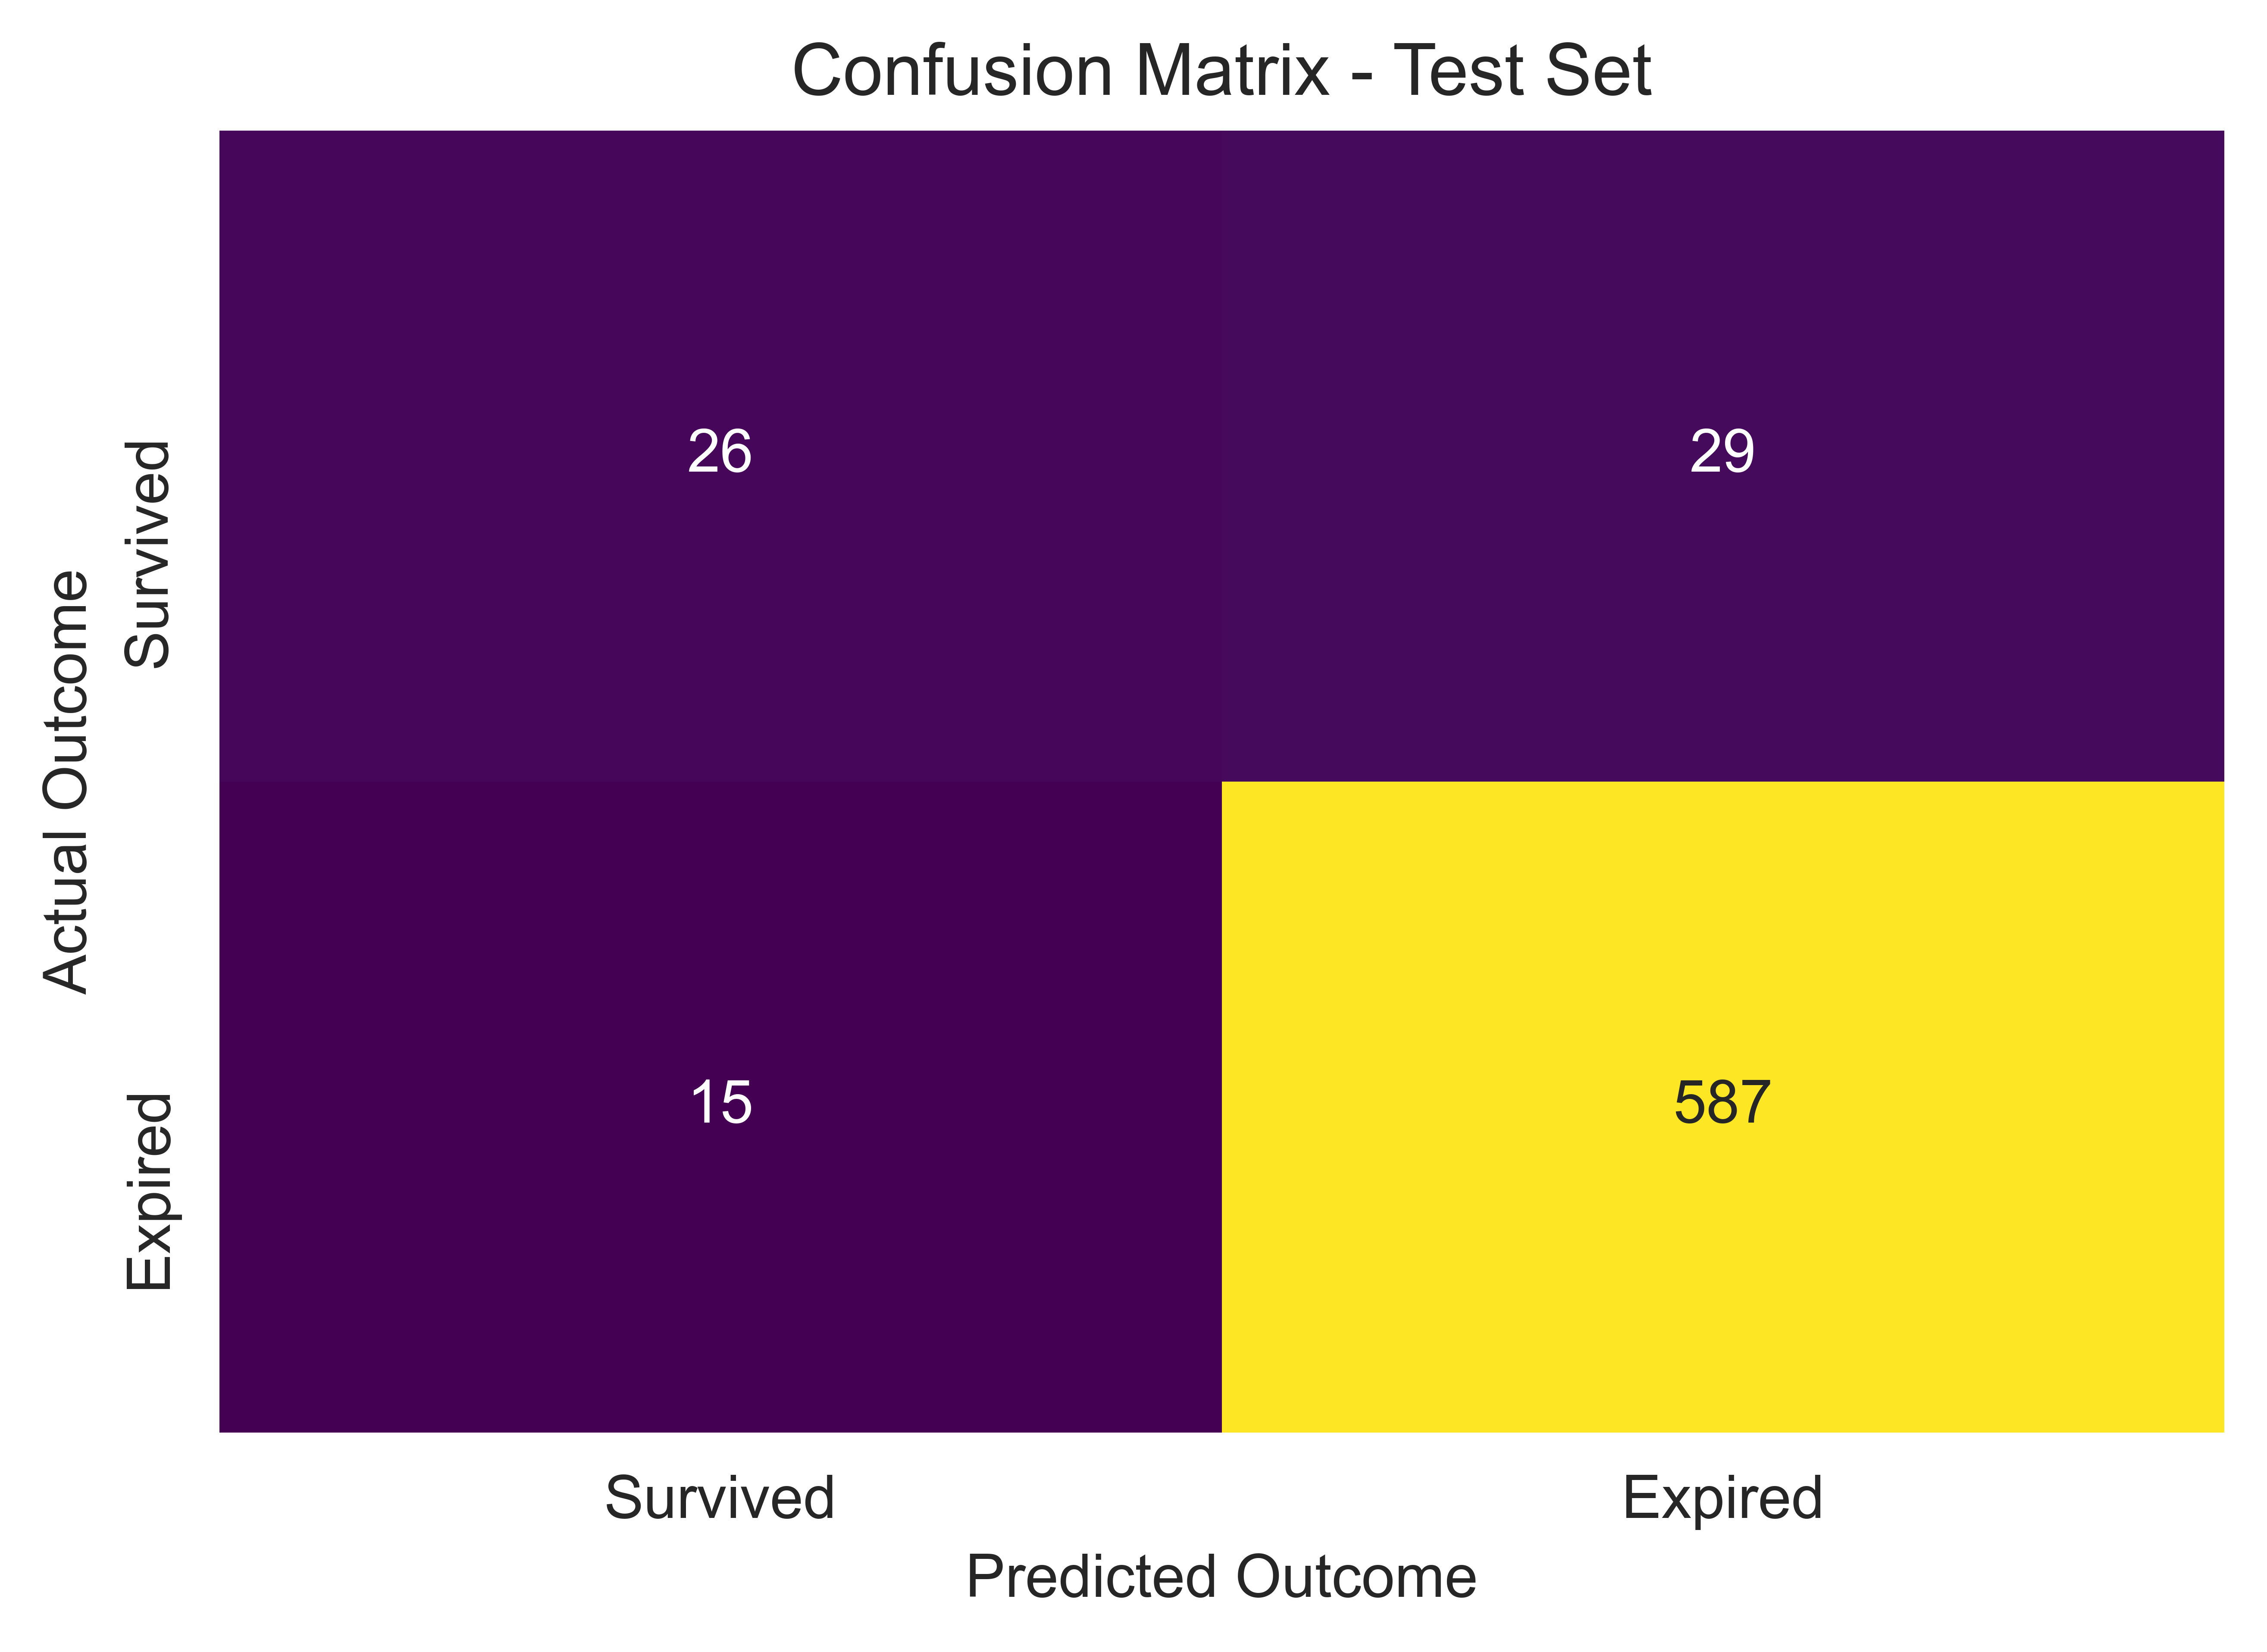

In [219]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

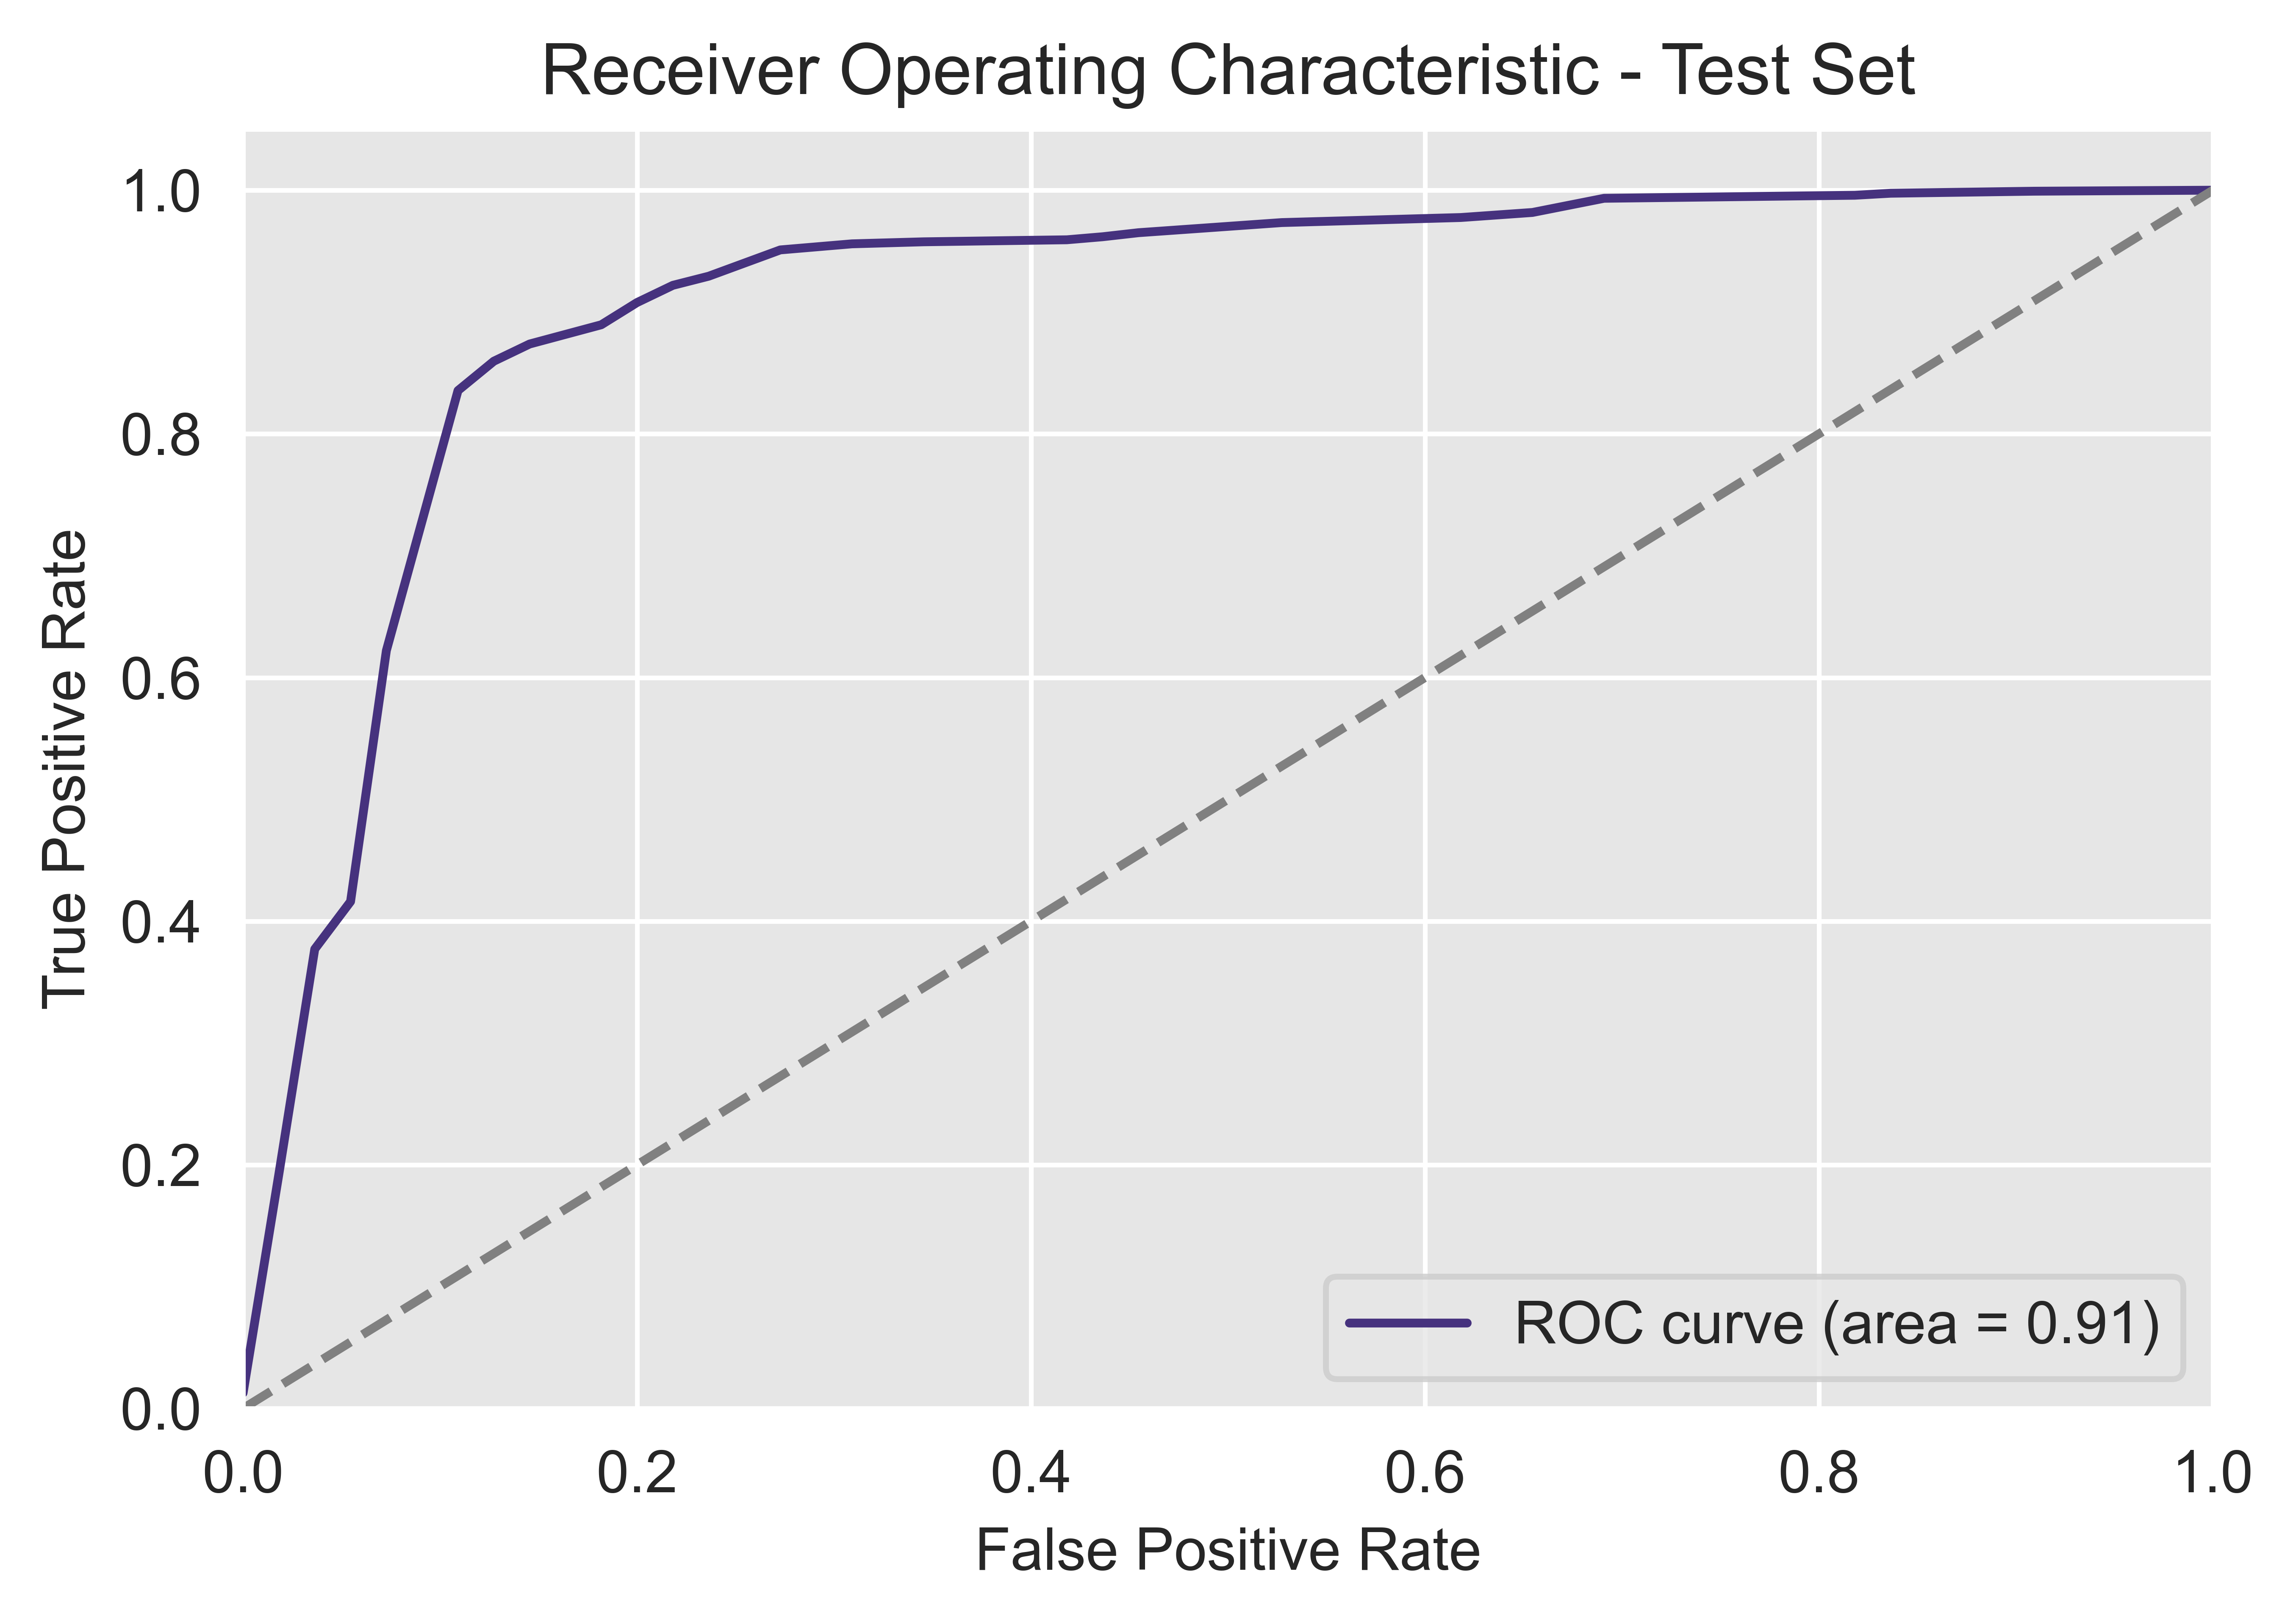

In [220]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_roc_curve(y_test, y_test_proba, 'Test Set')

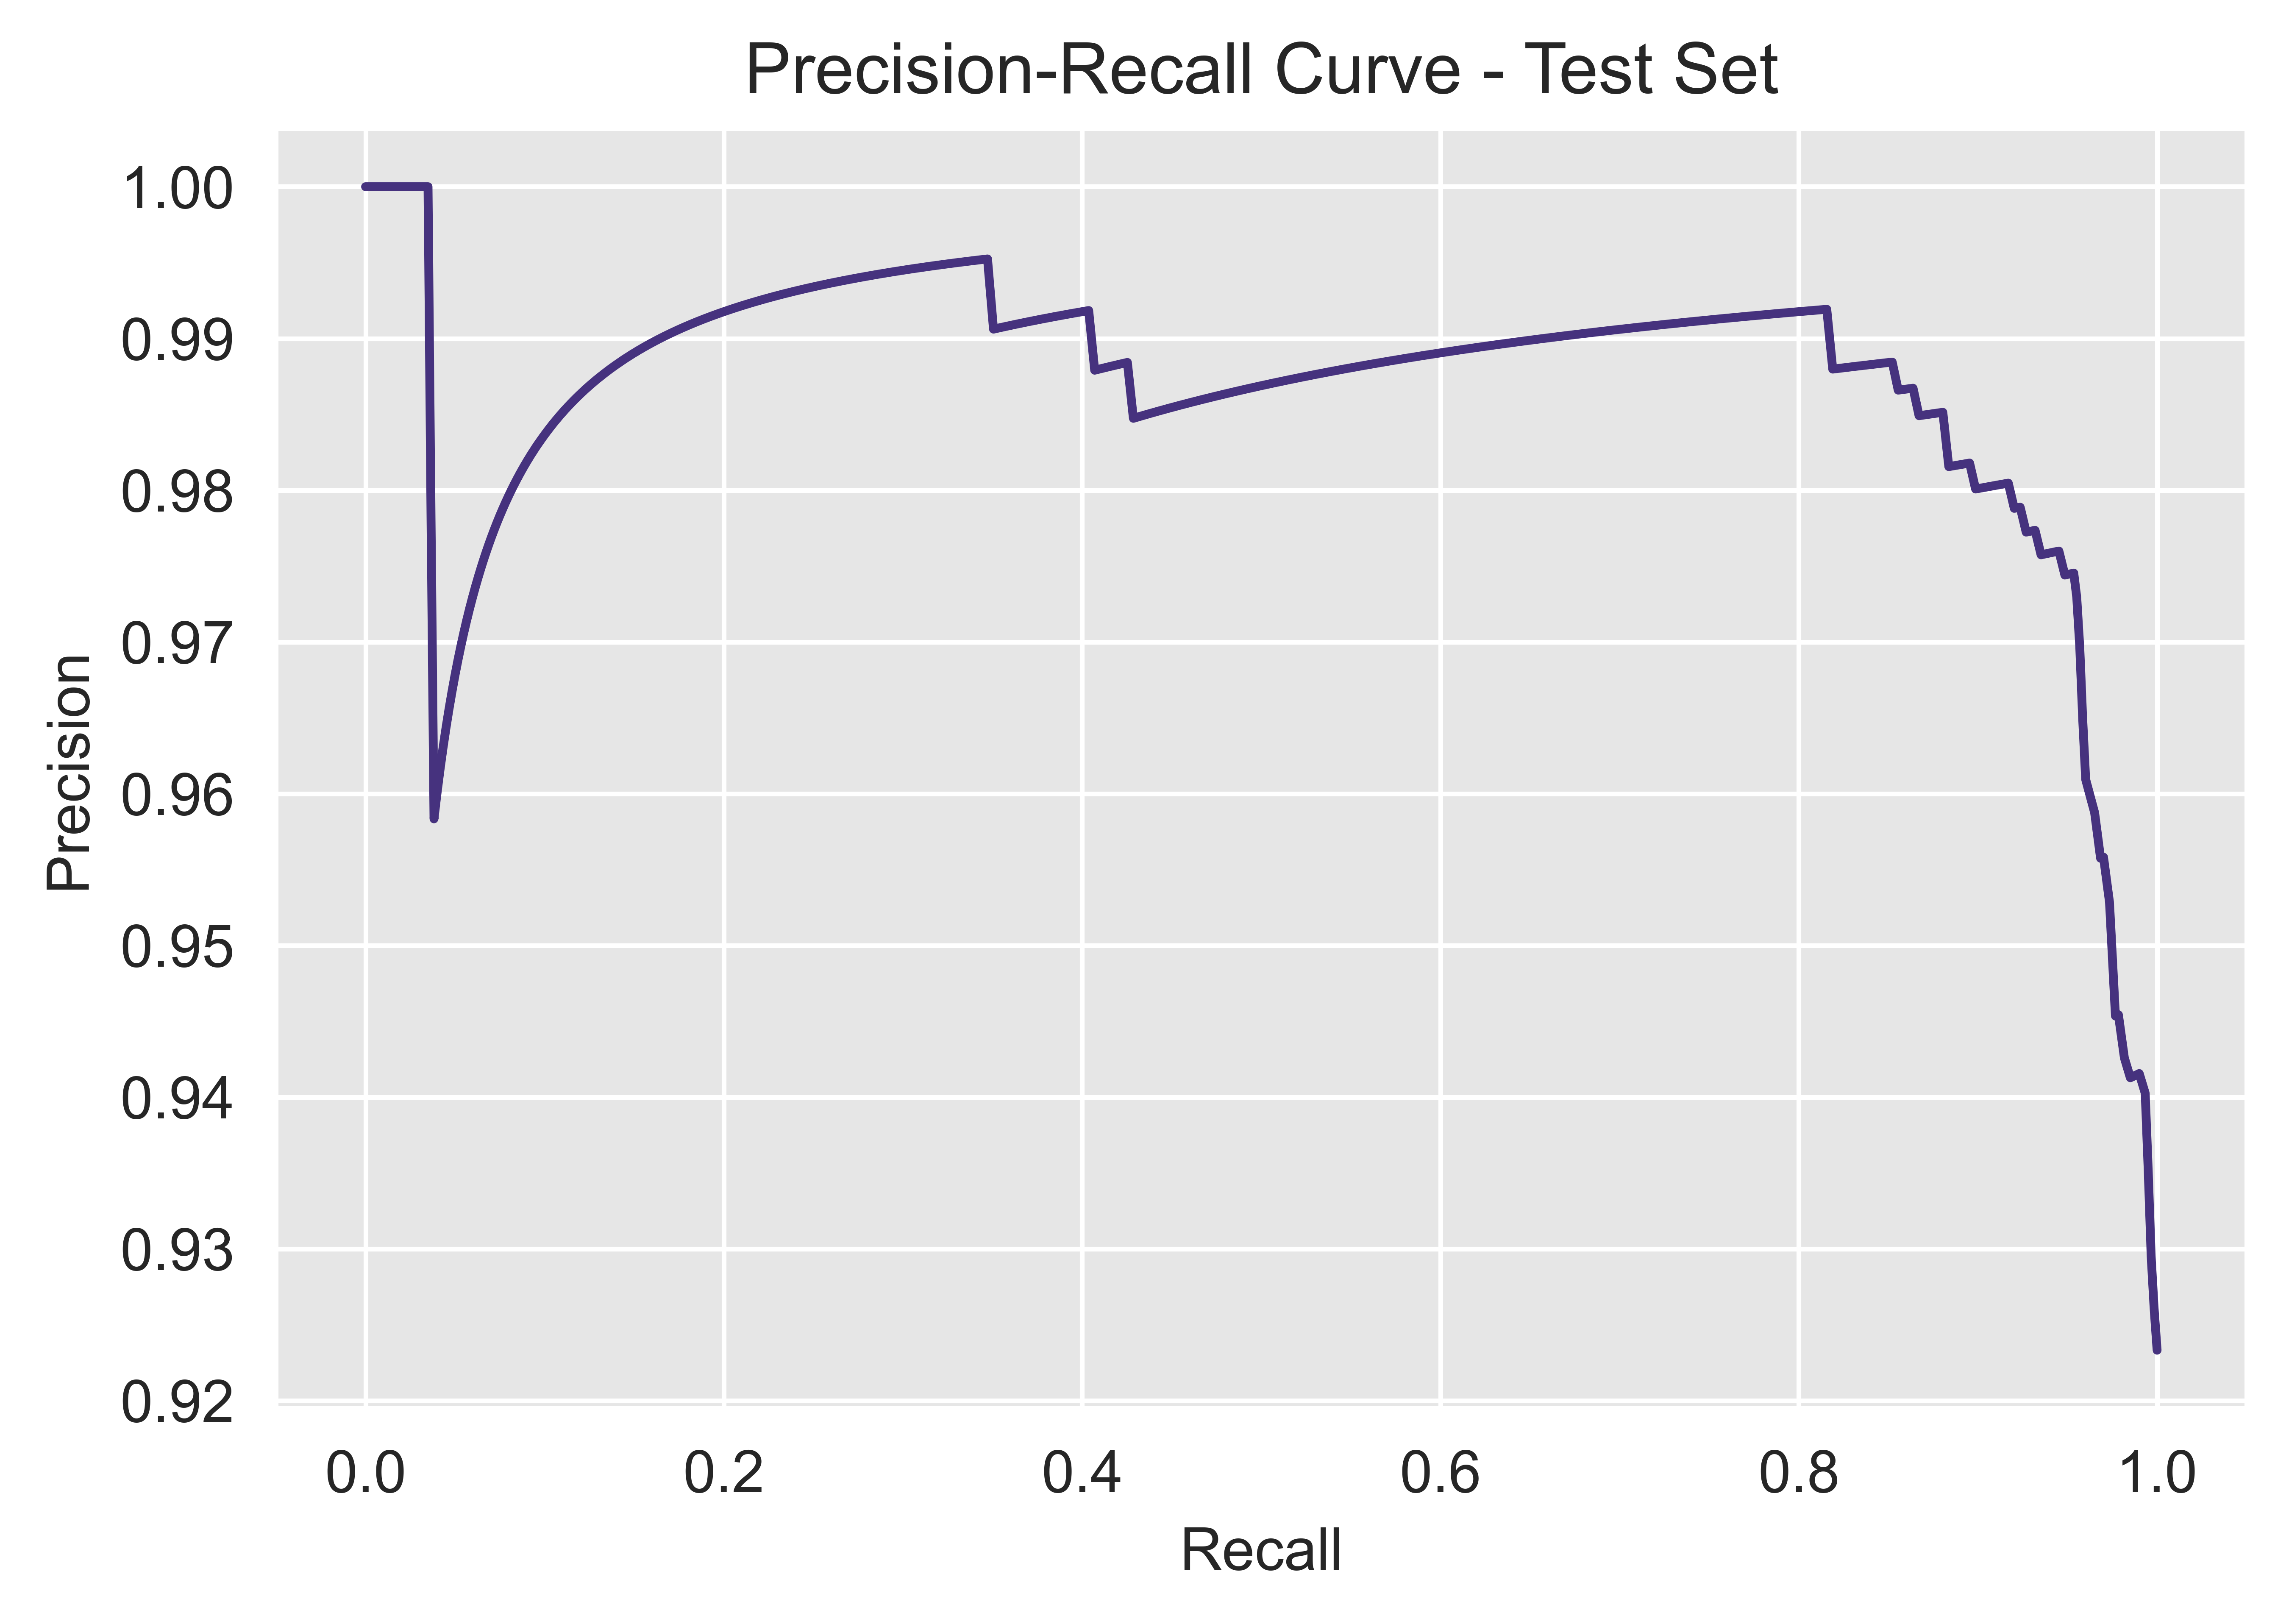

In [221]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')

## Perform machine learning while searching for best hyperparameters with Logistic Regression Model Using L2 Solver (LASSO)

In [222]:
# Tune hyperparameters

alphas = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001] # Coarse hyperparameter search

roc_auc_val_list = []

for alpha in alphas:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test, penalty='l2', iterations=1000, print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [223]:
roc_auc_val_df = pd.DataFrame({'Alpha':alphas, 'AUROC':roc_auc_val_list})
best_alpha = alphas[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['Alpha'] == best_alpha])

Alpha     AUROC
0  1.00000  0.902647
1  0.10000  0.904553
2  0.01000  0.899229
3  0.00100  0.901891
4  0.00010  0.901104
5  0.00001  0.901407

Alpha     AUROC
1    0.1  0.904553

## Re-train with best alpha value

In [224]:
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(best_alpha, X_train, y_train, X_val, y_val, X_test, y_test, iterations=1000, print_out=False)

## Generate plots for analysis

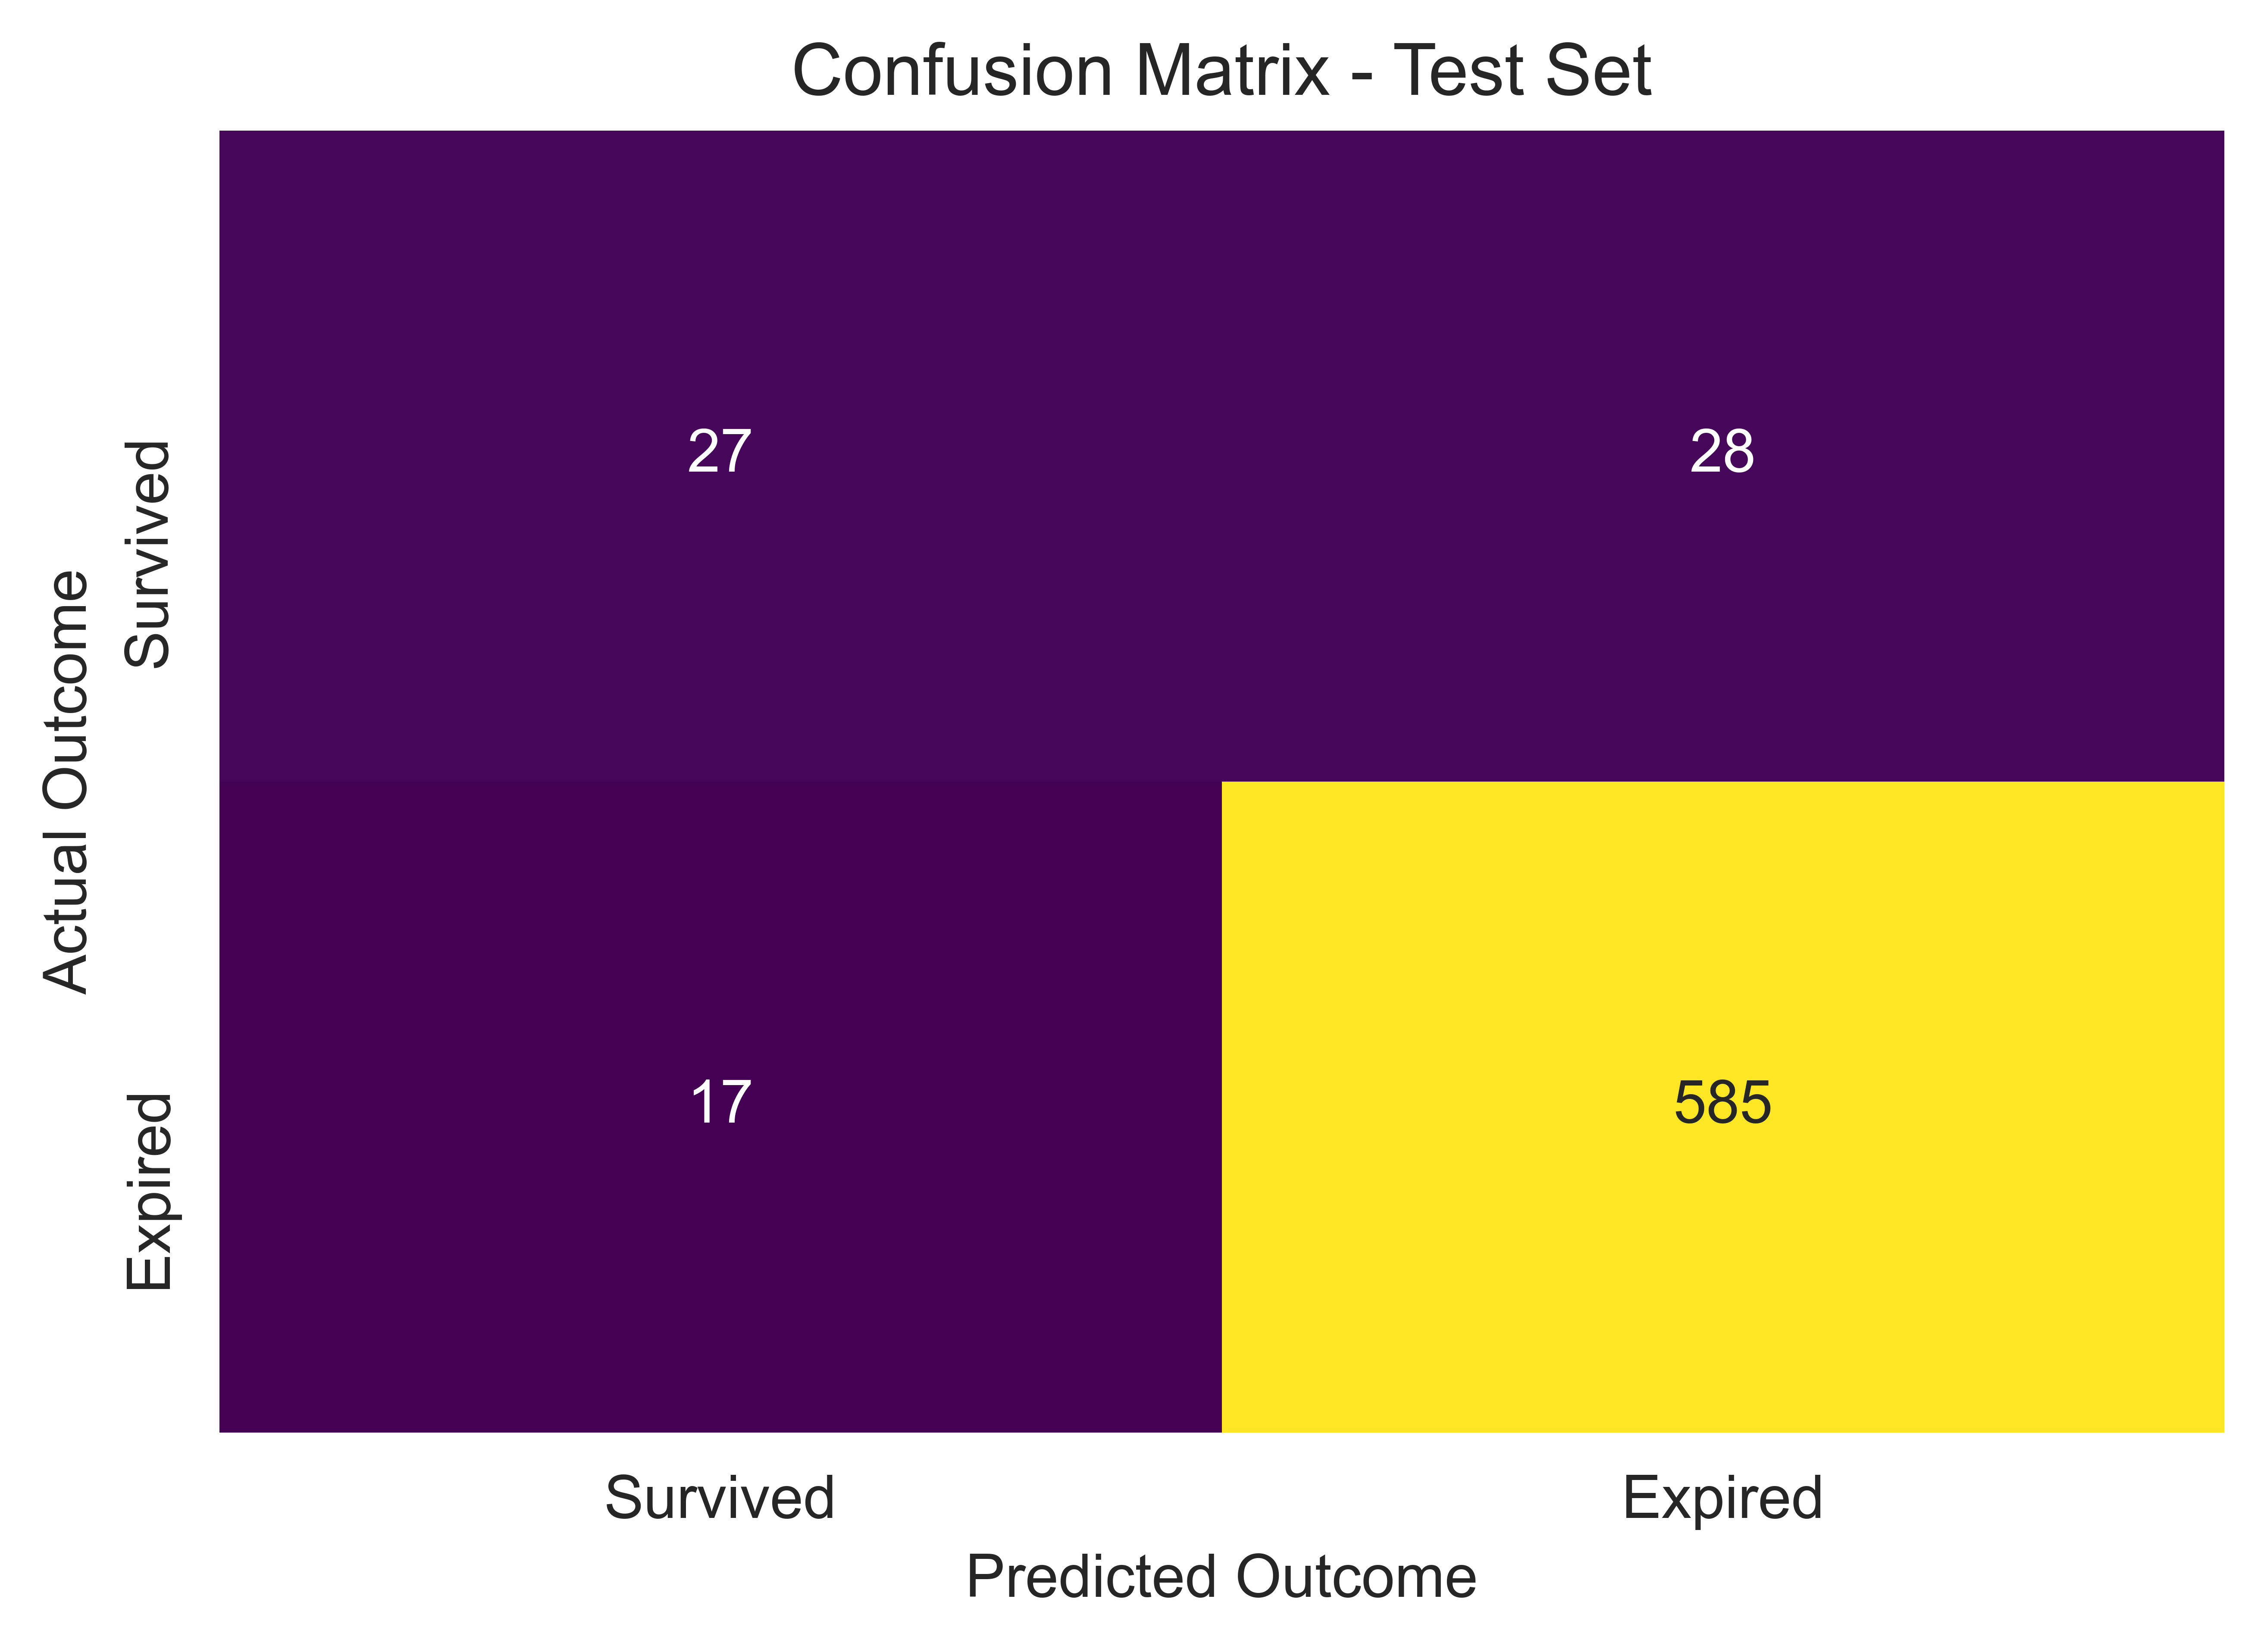

In [225]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

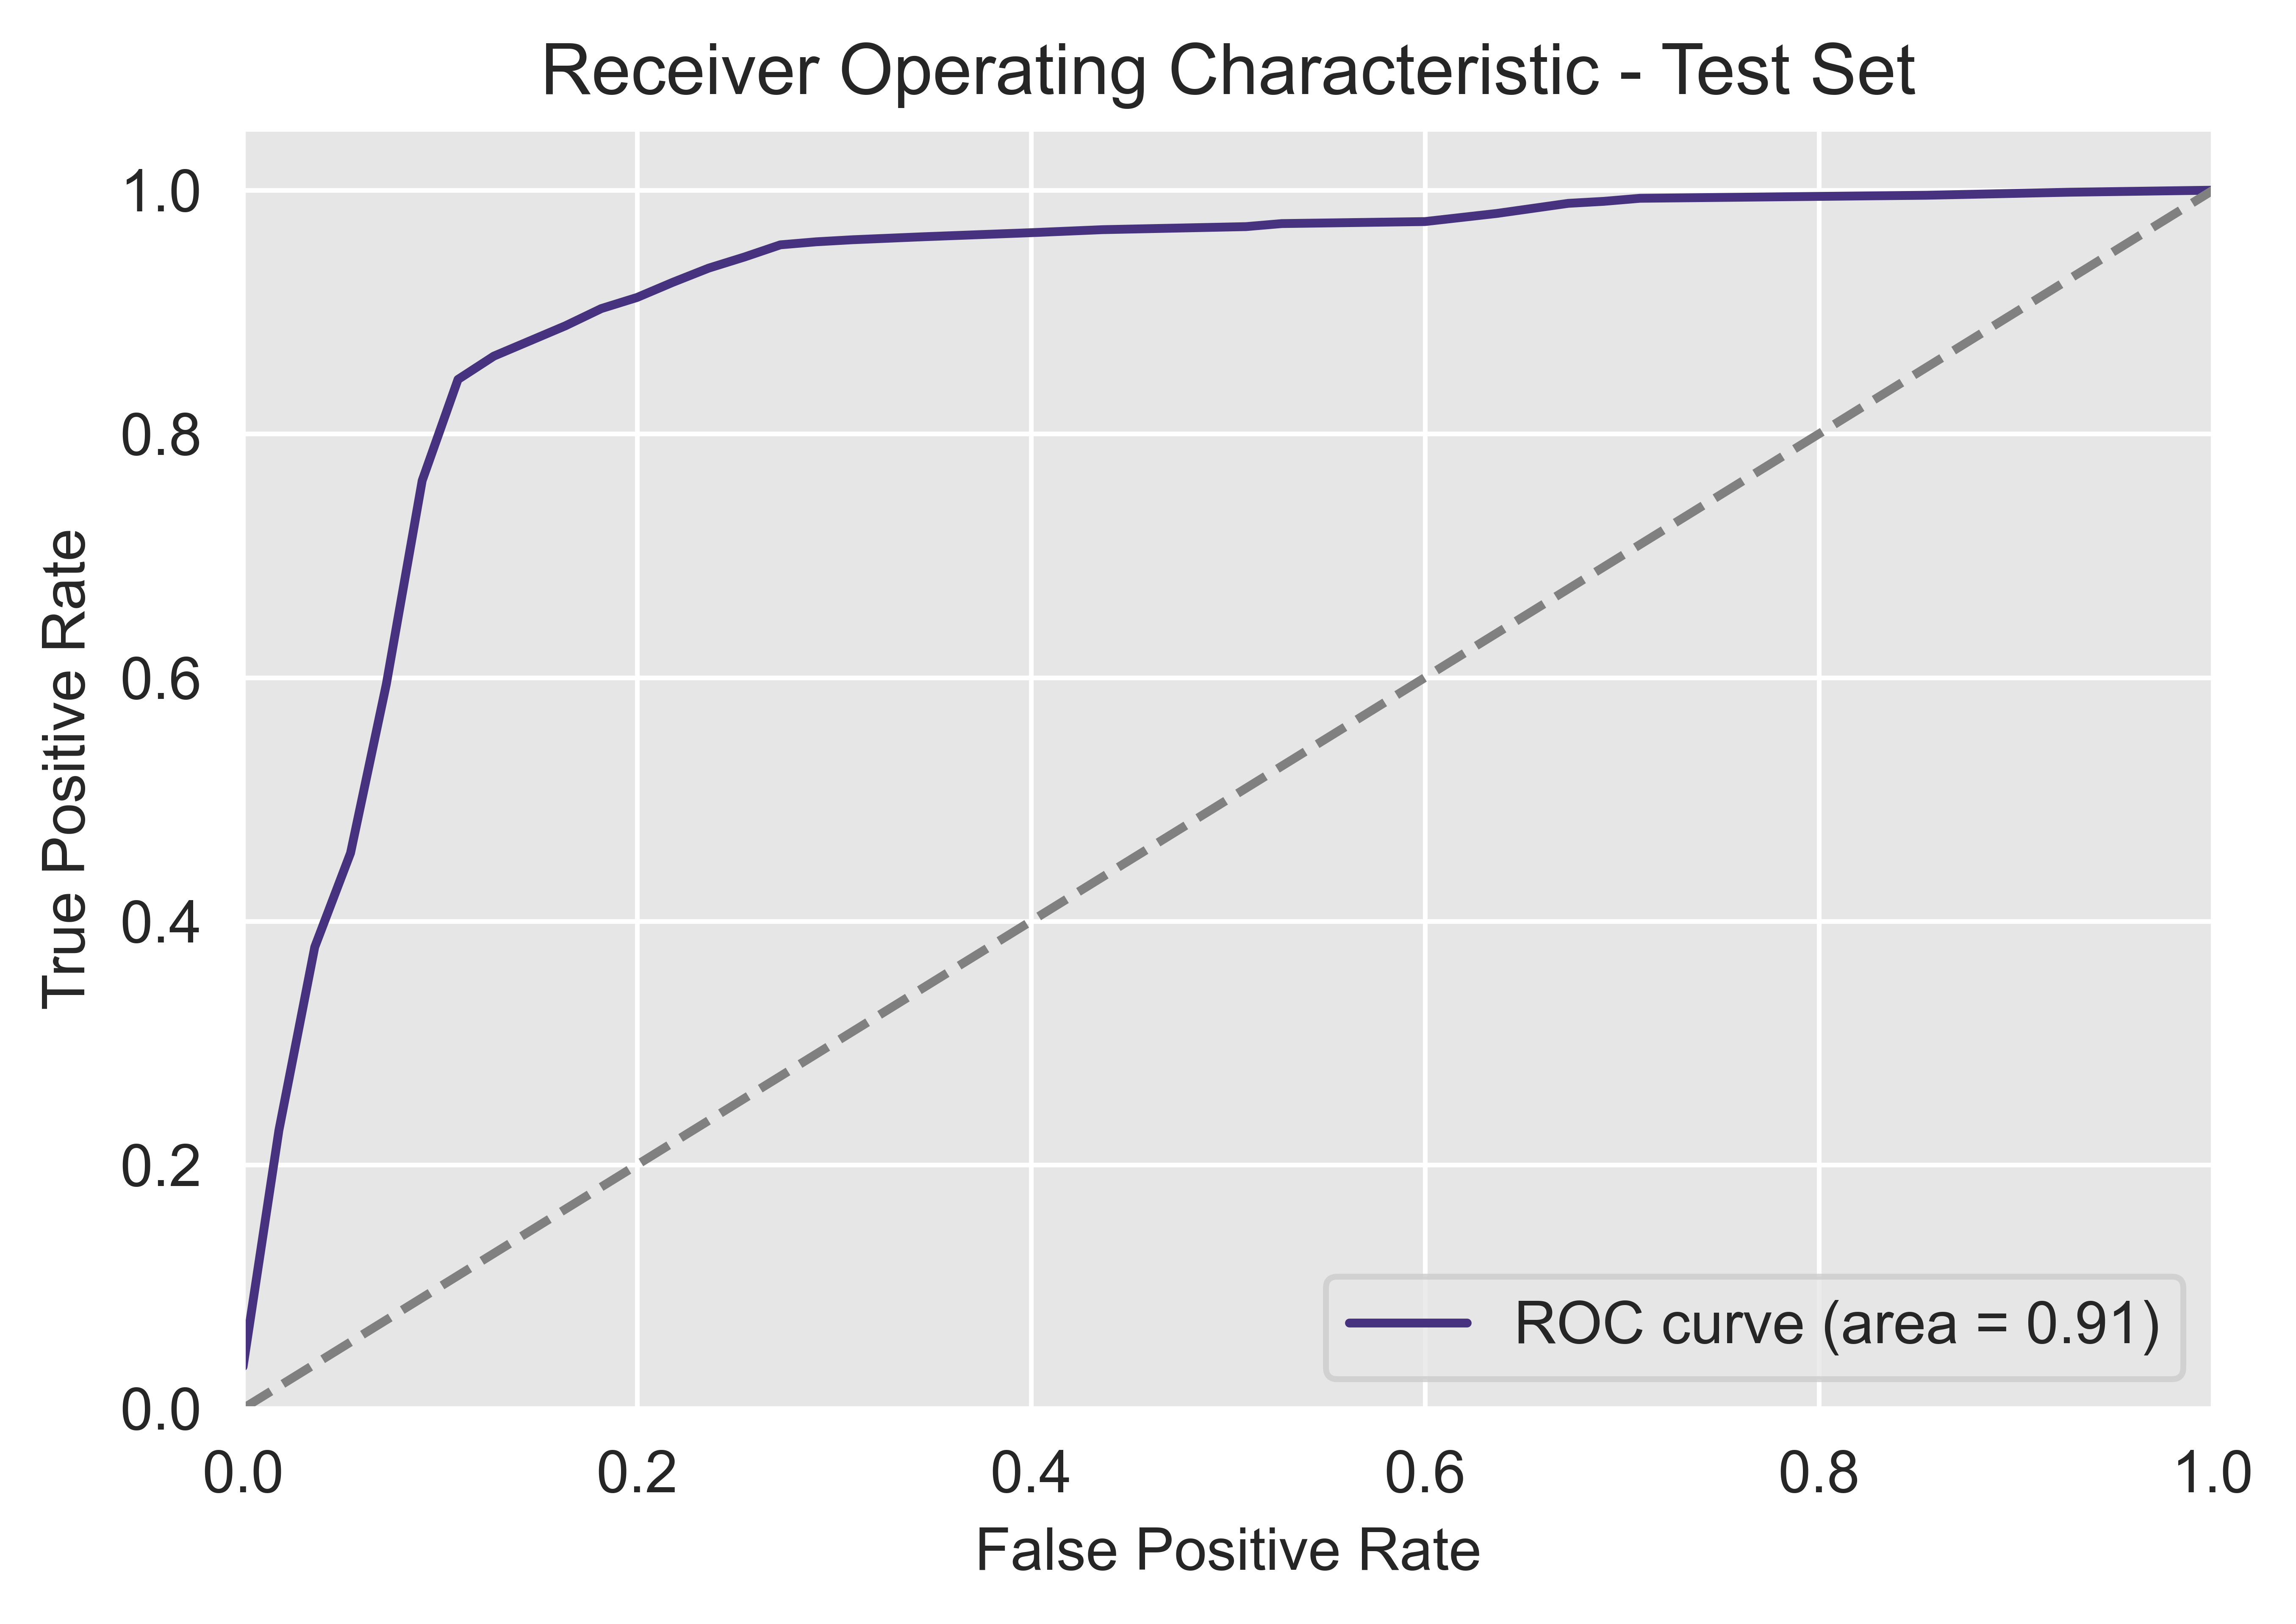

In [226]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_roc_curve(y_test, y_test_proba, 'Test Set')

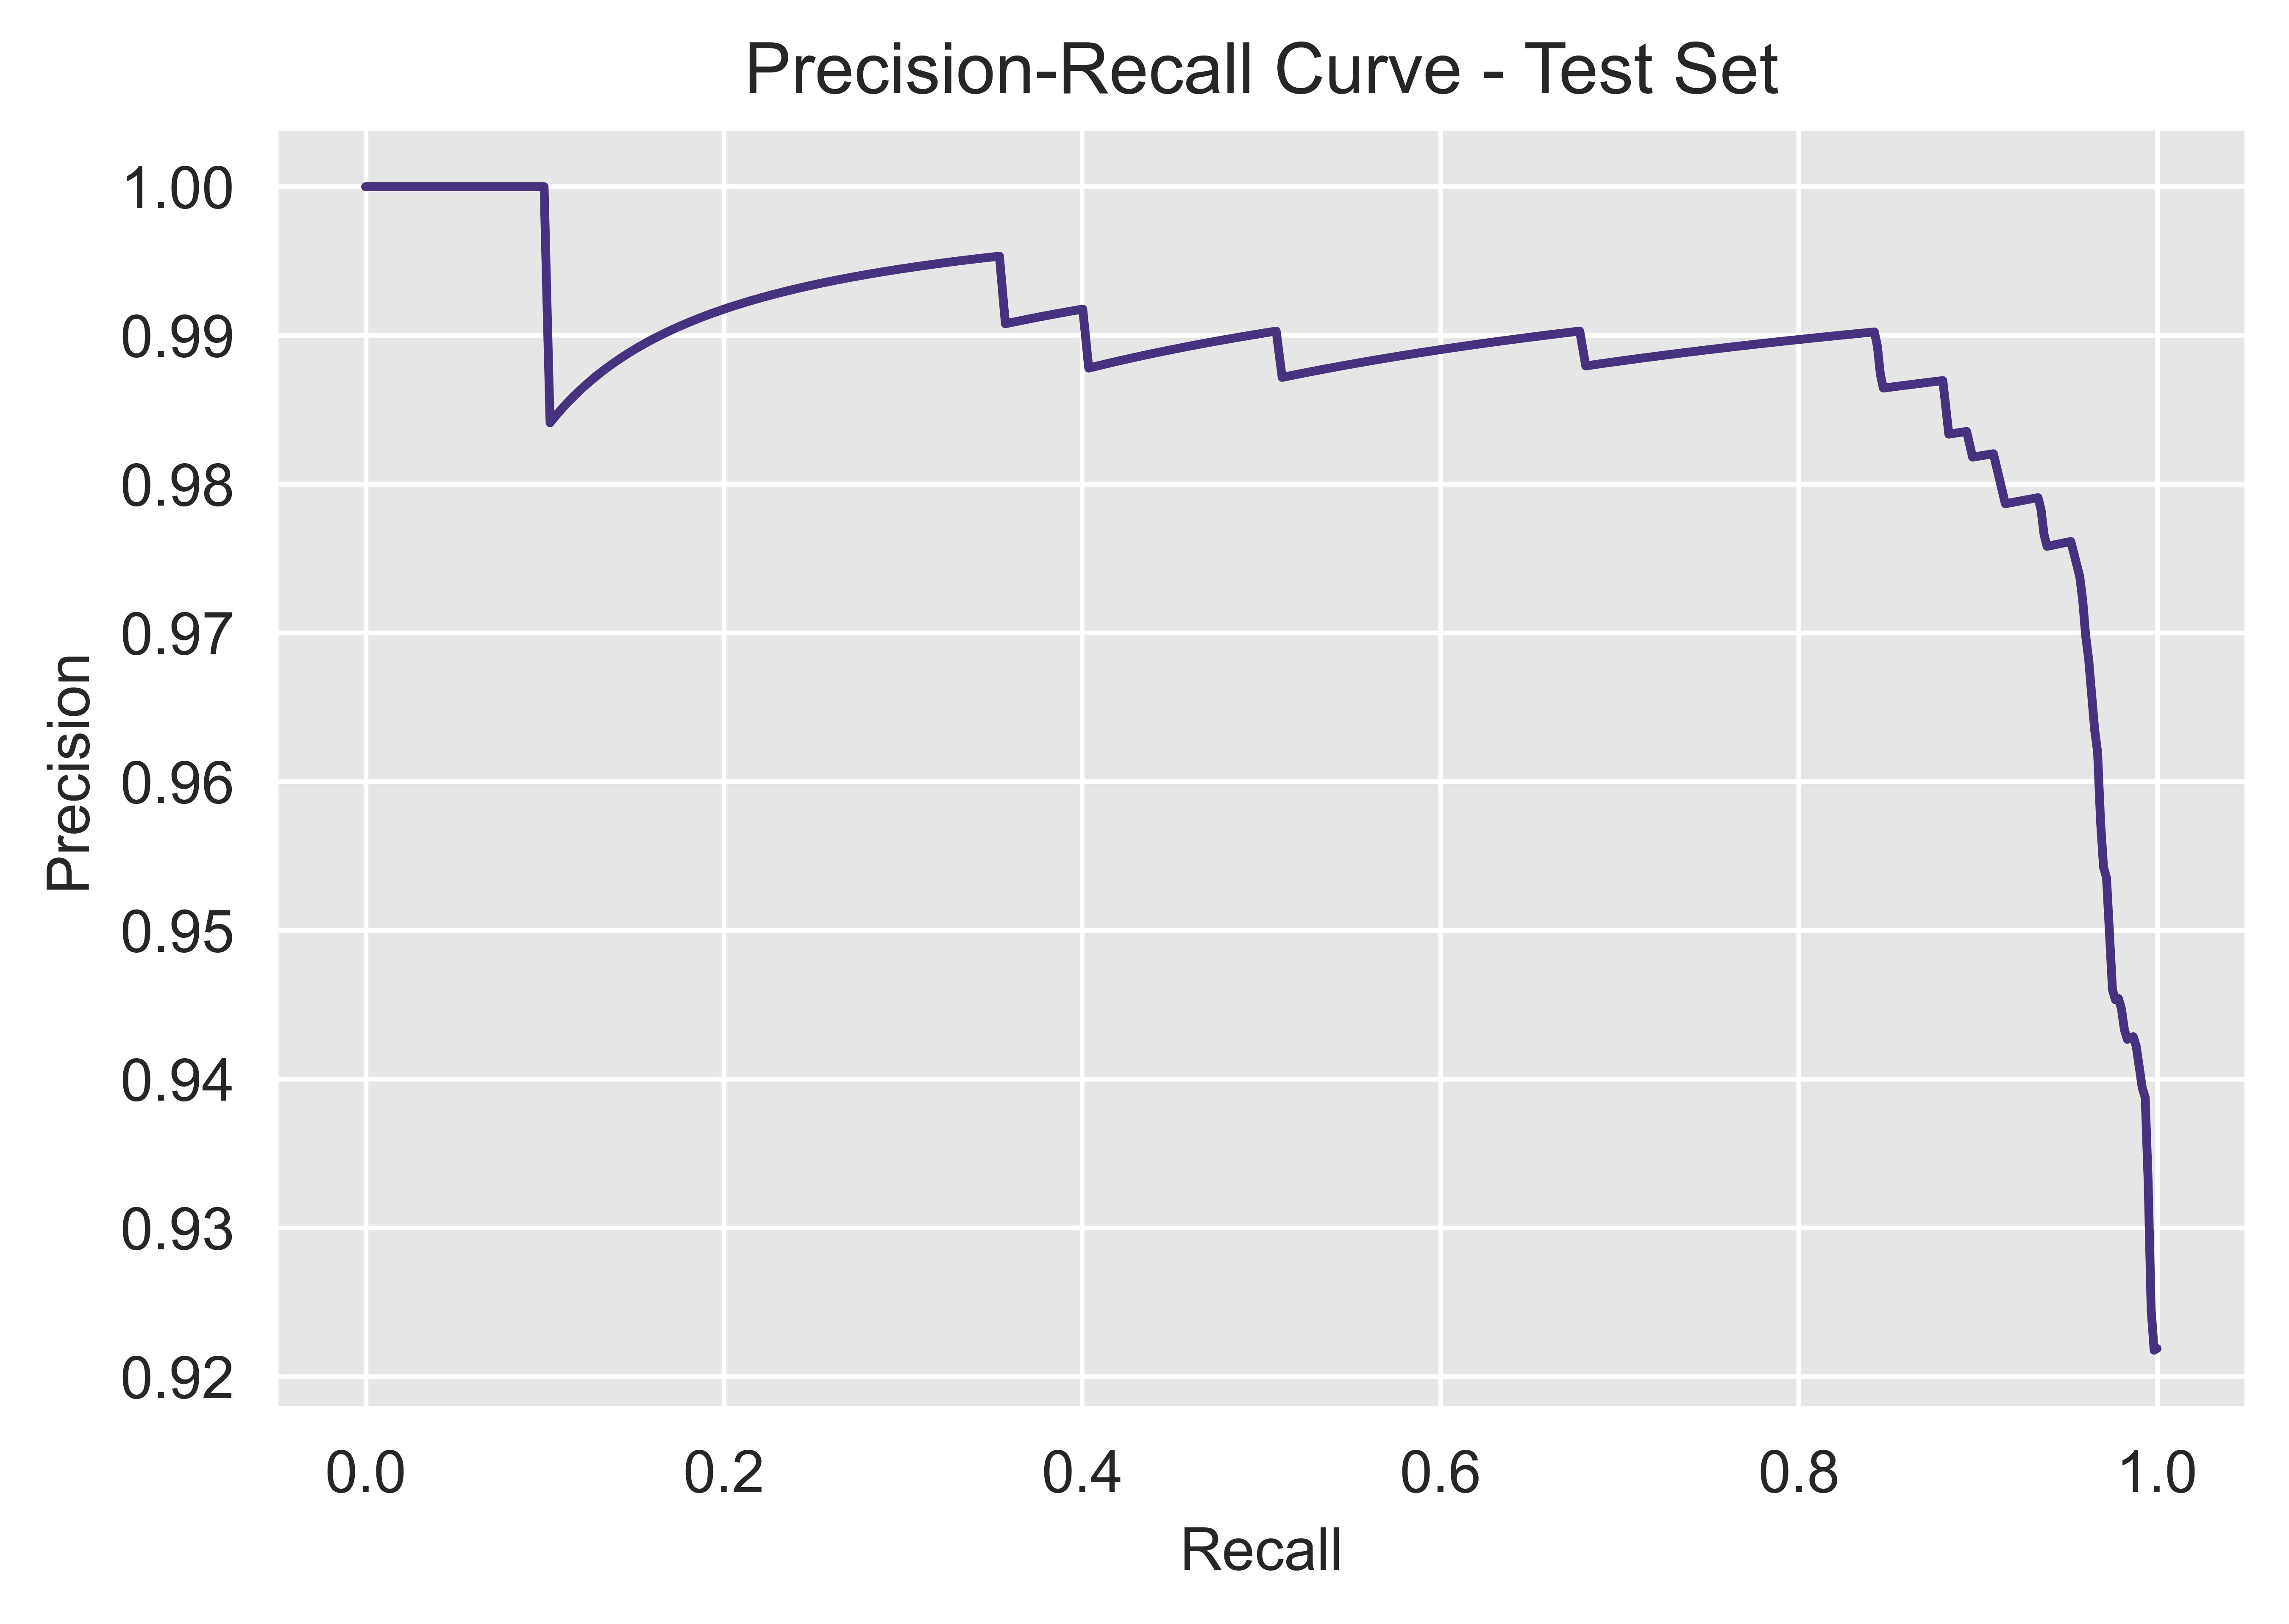

In [227]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')

## Perform machine learning while searching for best hyperparameters with Logistic Regression Model Using Elastic Net Penalty

> Technically we need to tune `l1_ratio` separately. For now we will just use `0.5` to use a balanced approach.

In [234]:
# Tune hyperparameters

alphas = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001] # Coarse hyperparameter search

roc_auc_val_list = []

for alpha in alphas:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test, l1_ratio=0.5, penalty='elasticnet', iterations=10000, solver='saga', print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [235]:
roc_auc_val_df = pd.DataFrame({'Alpha':alphas, 'AUROC':roc_auc_val_list})
best_alpha = alphas[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['Alpha'] == best_alpha])

Alpha     AUROC
0  1.00000  0.843987
1  0.10000  0.844048
2  0.01000  0.844048
3  0.00100  0.844048
4  0.00010  0.844048
5  0.00001  0.844048

Alpha     AUROC
1    0.1  0.844048

## Re-train with best alpha value

In [236]:
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(best_alpha, X_train, y_train, X_val, y_val, X_test, y_test, iterations=1000, print_out=False)

## Generate plots for analysis

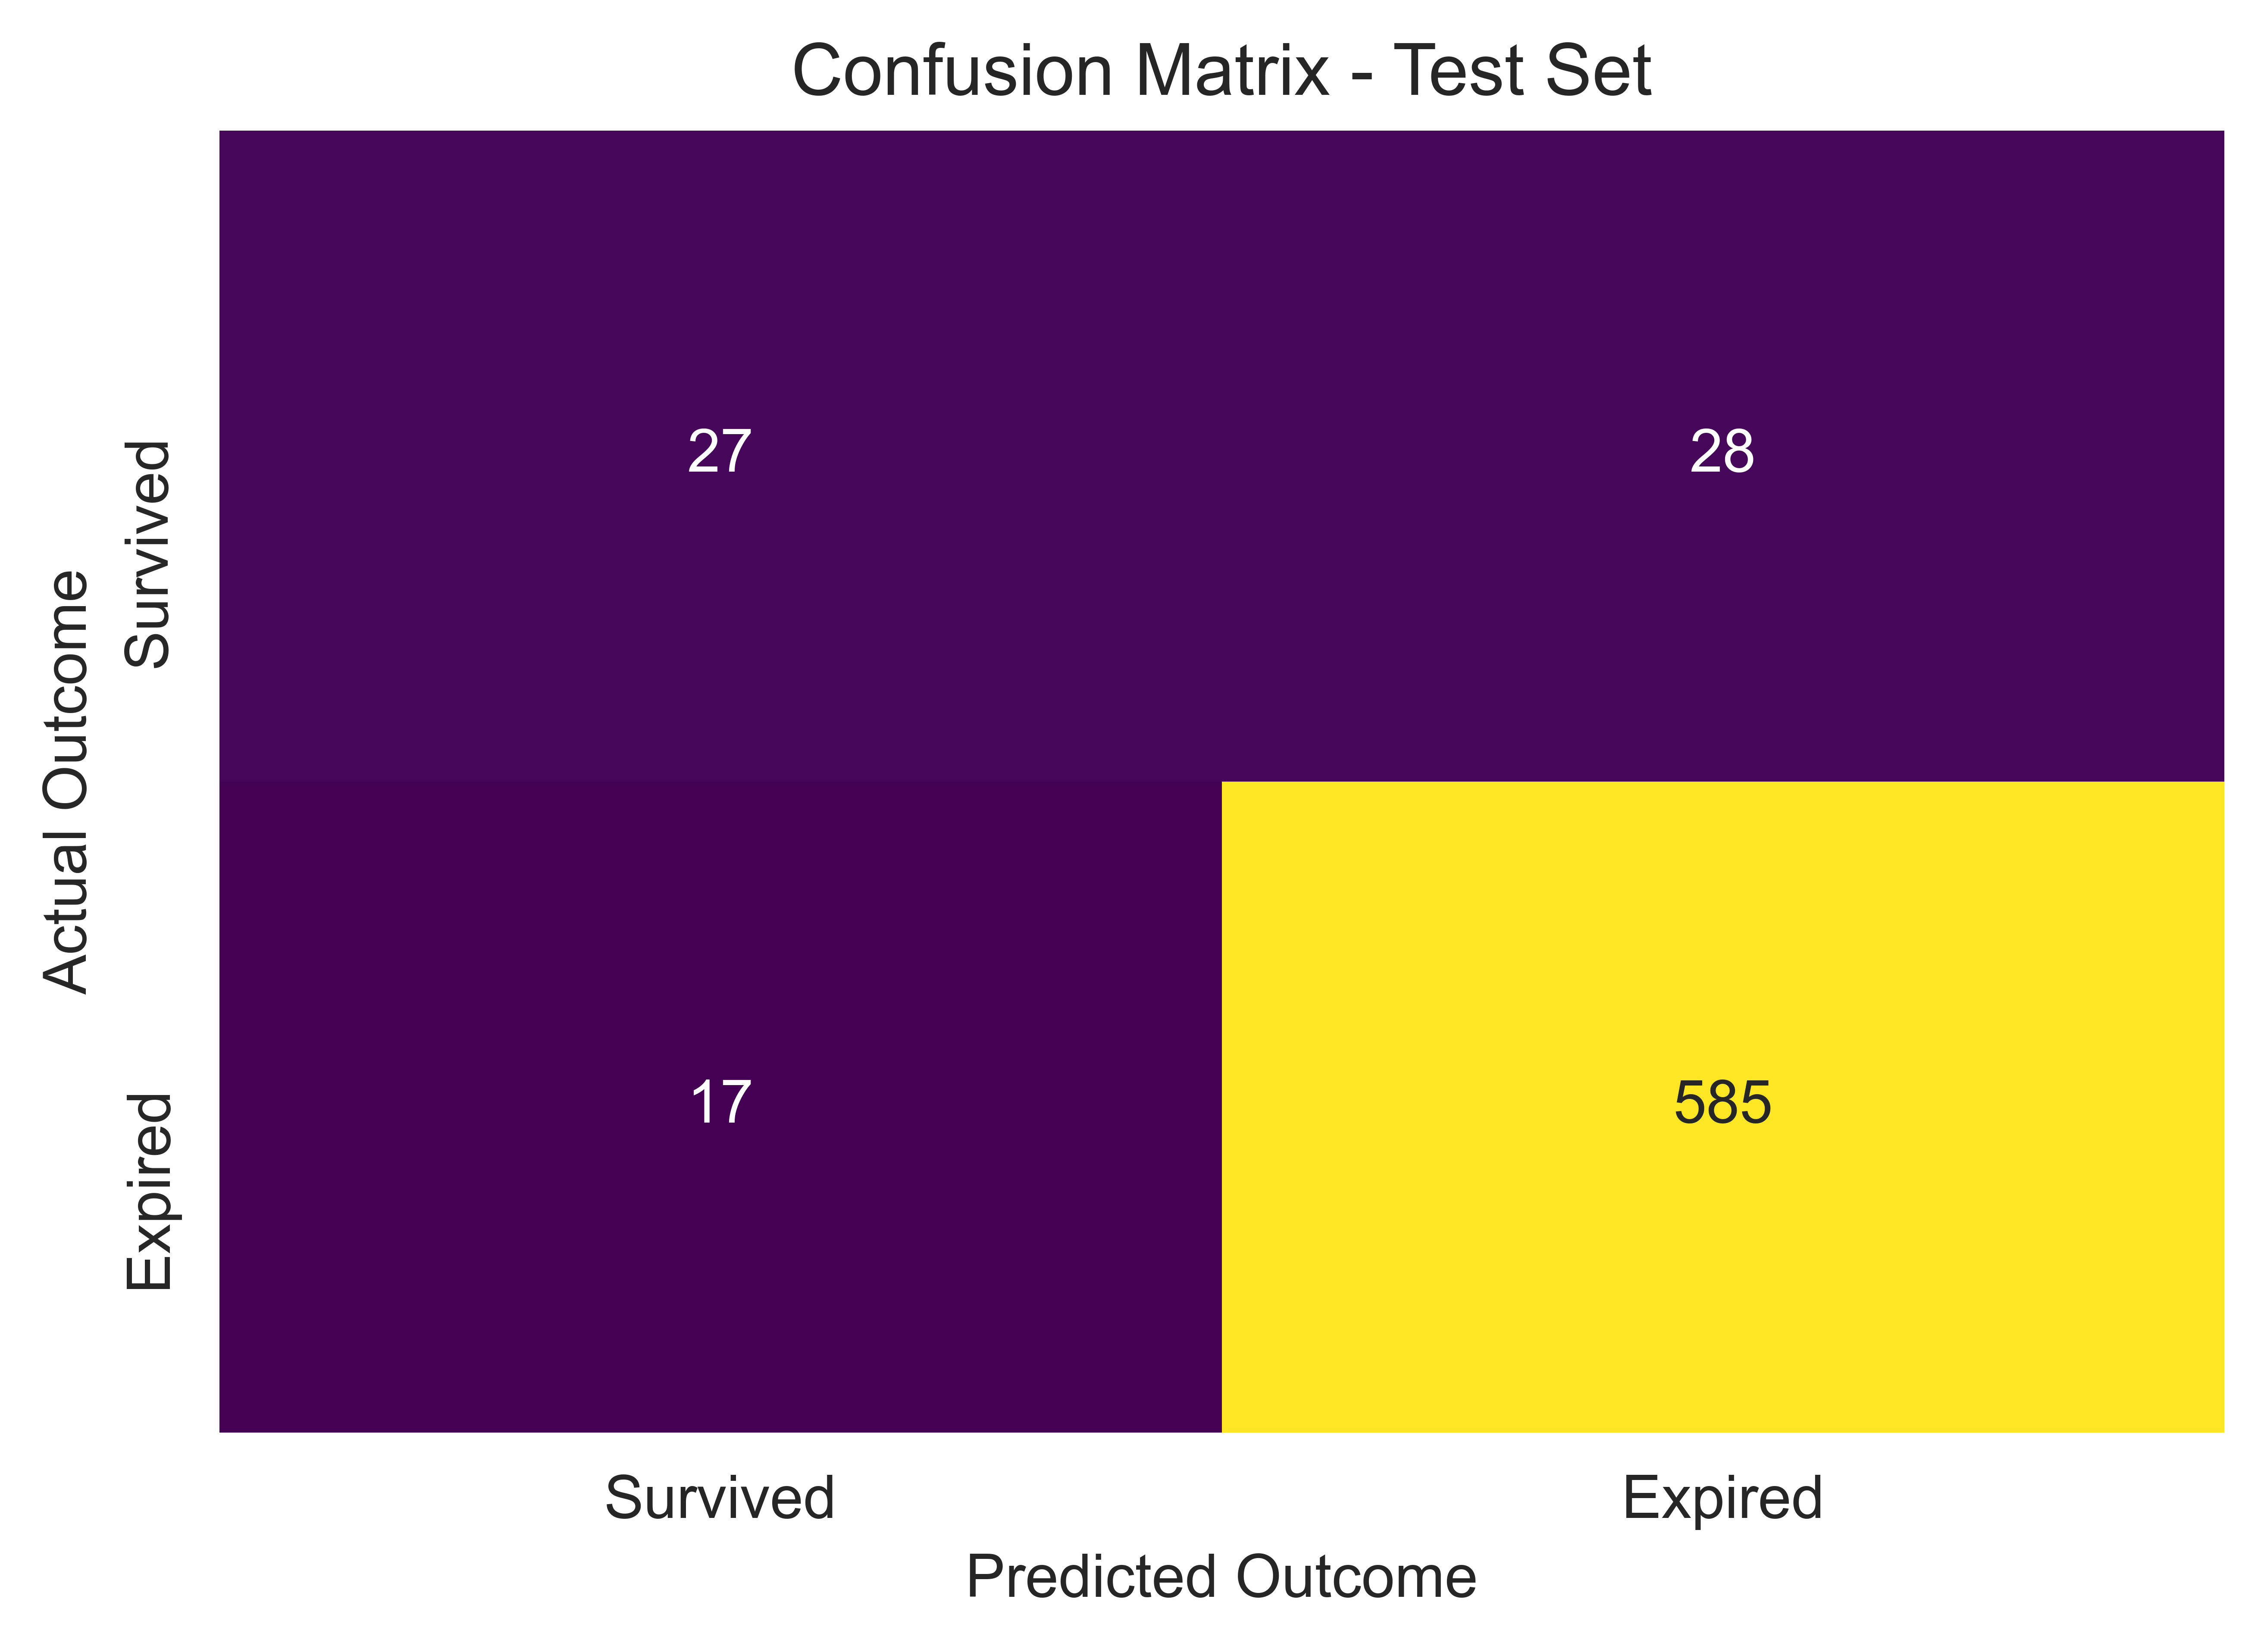

In [237]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

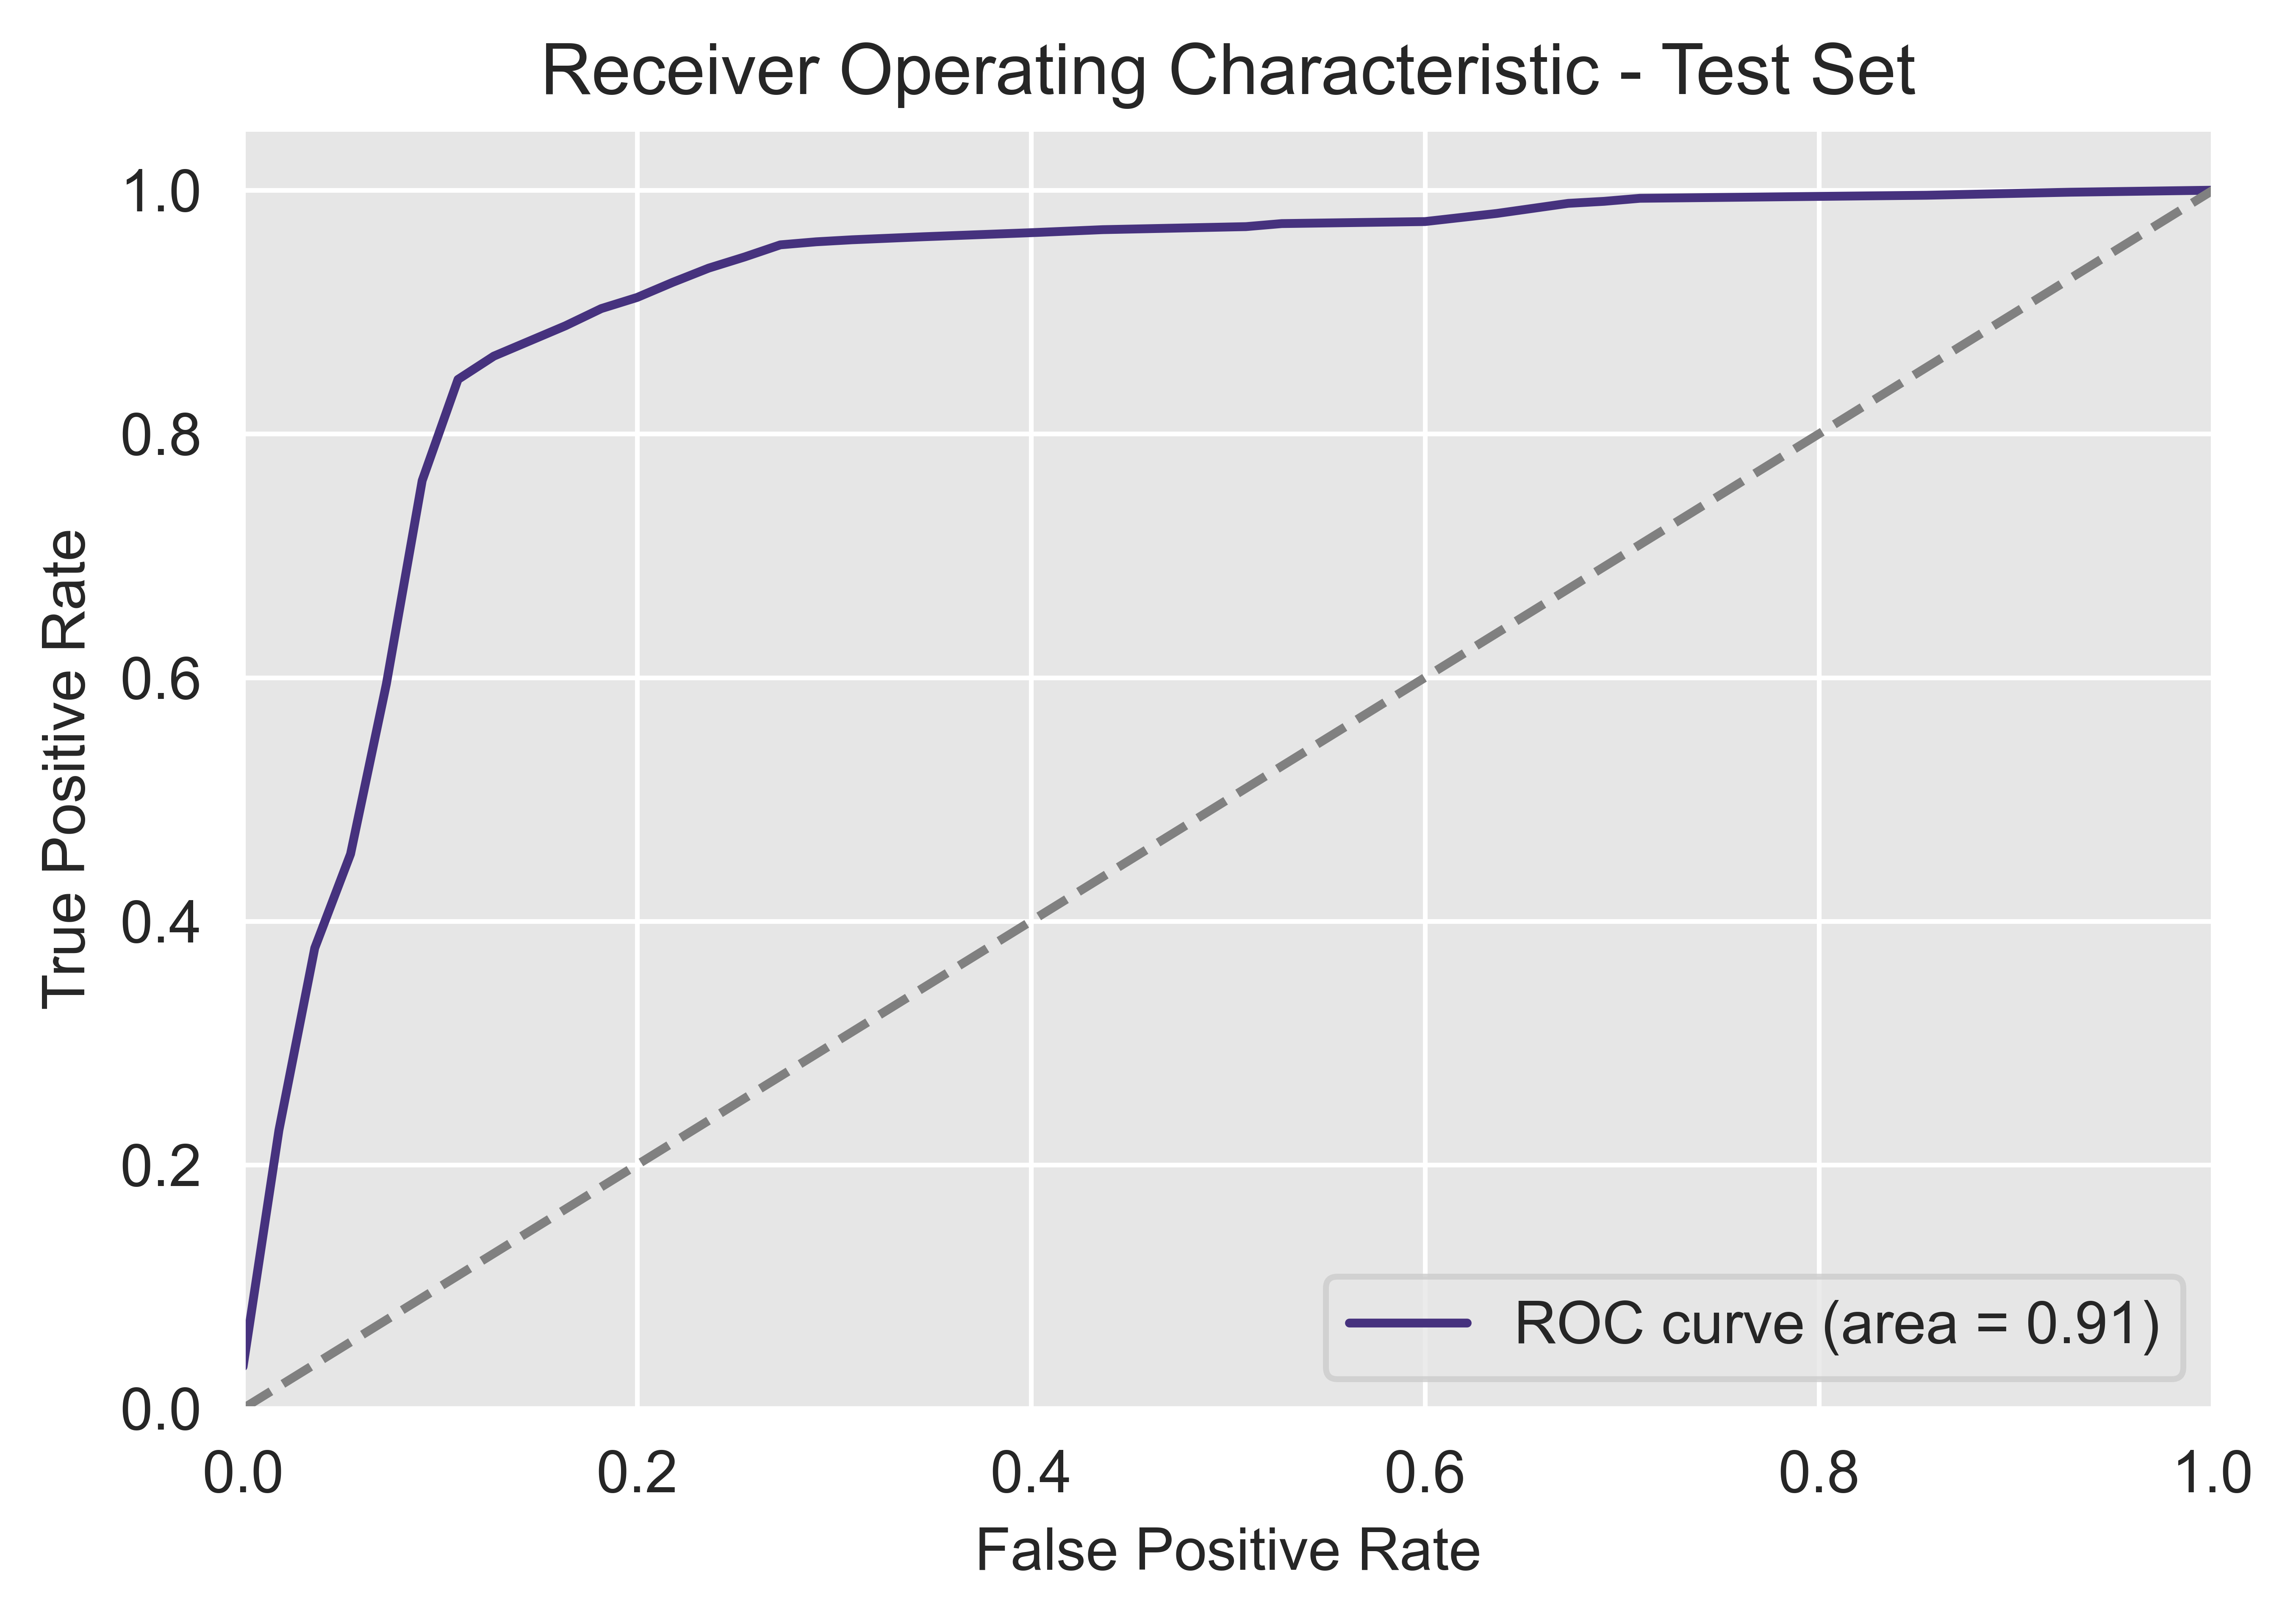

In [238]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_roc_curve(y_test, y_test_proba, 'Test Set')

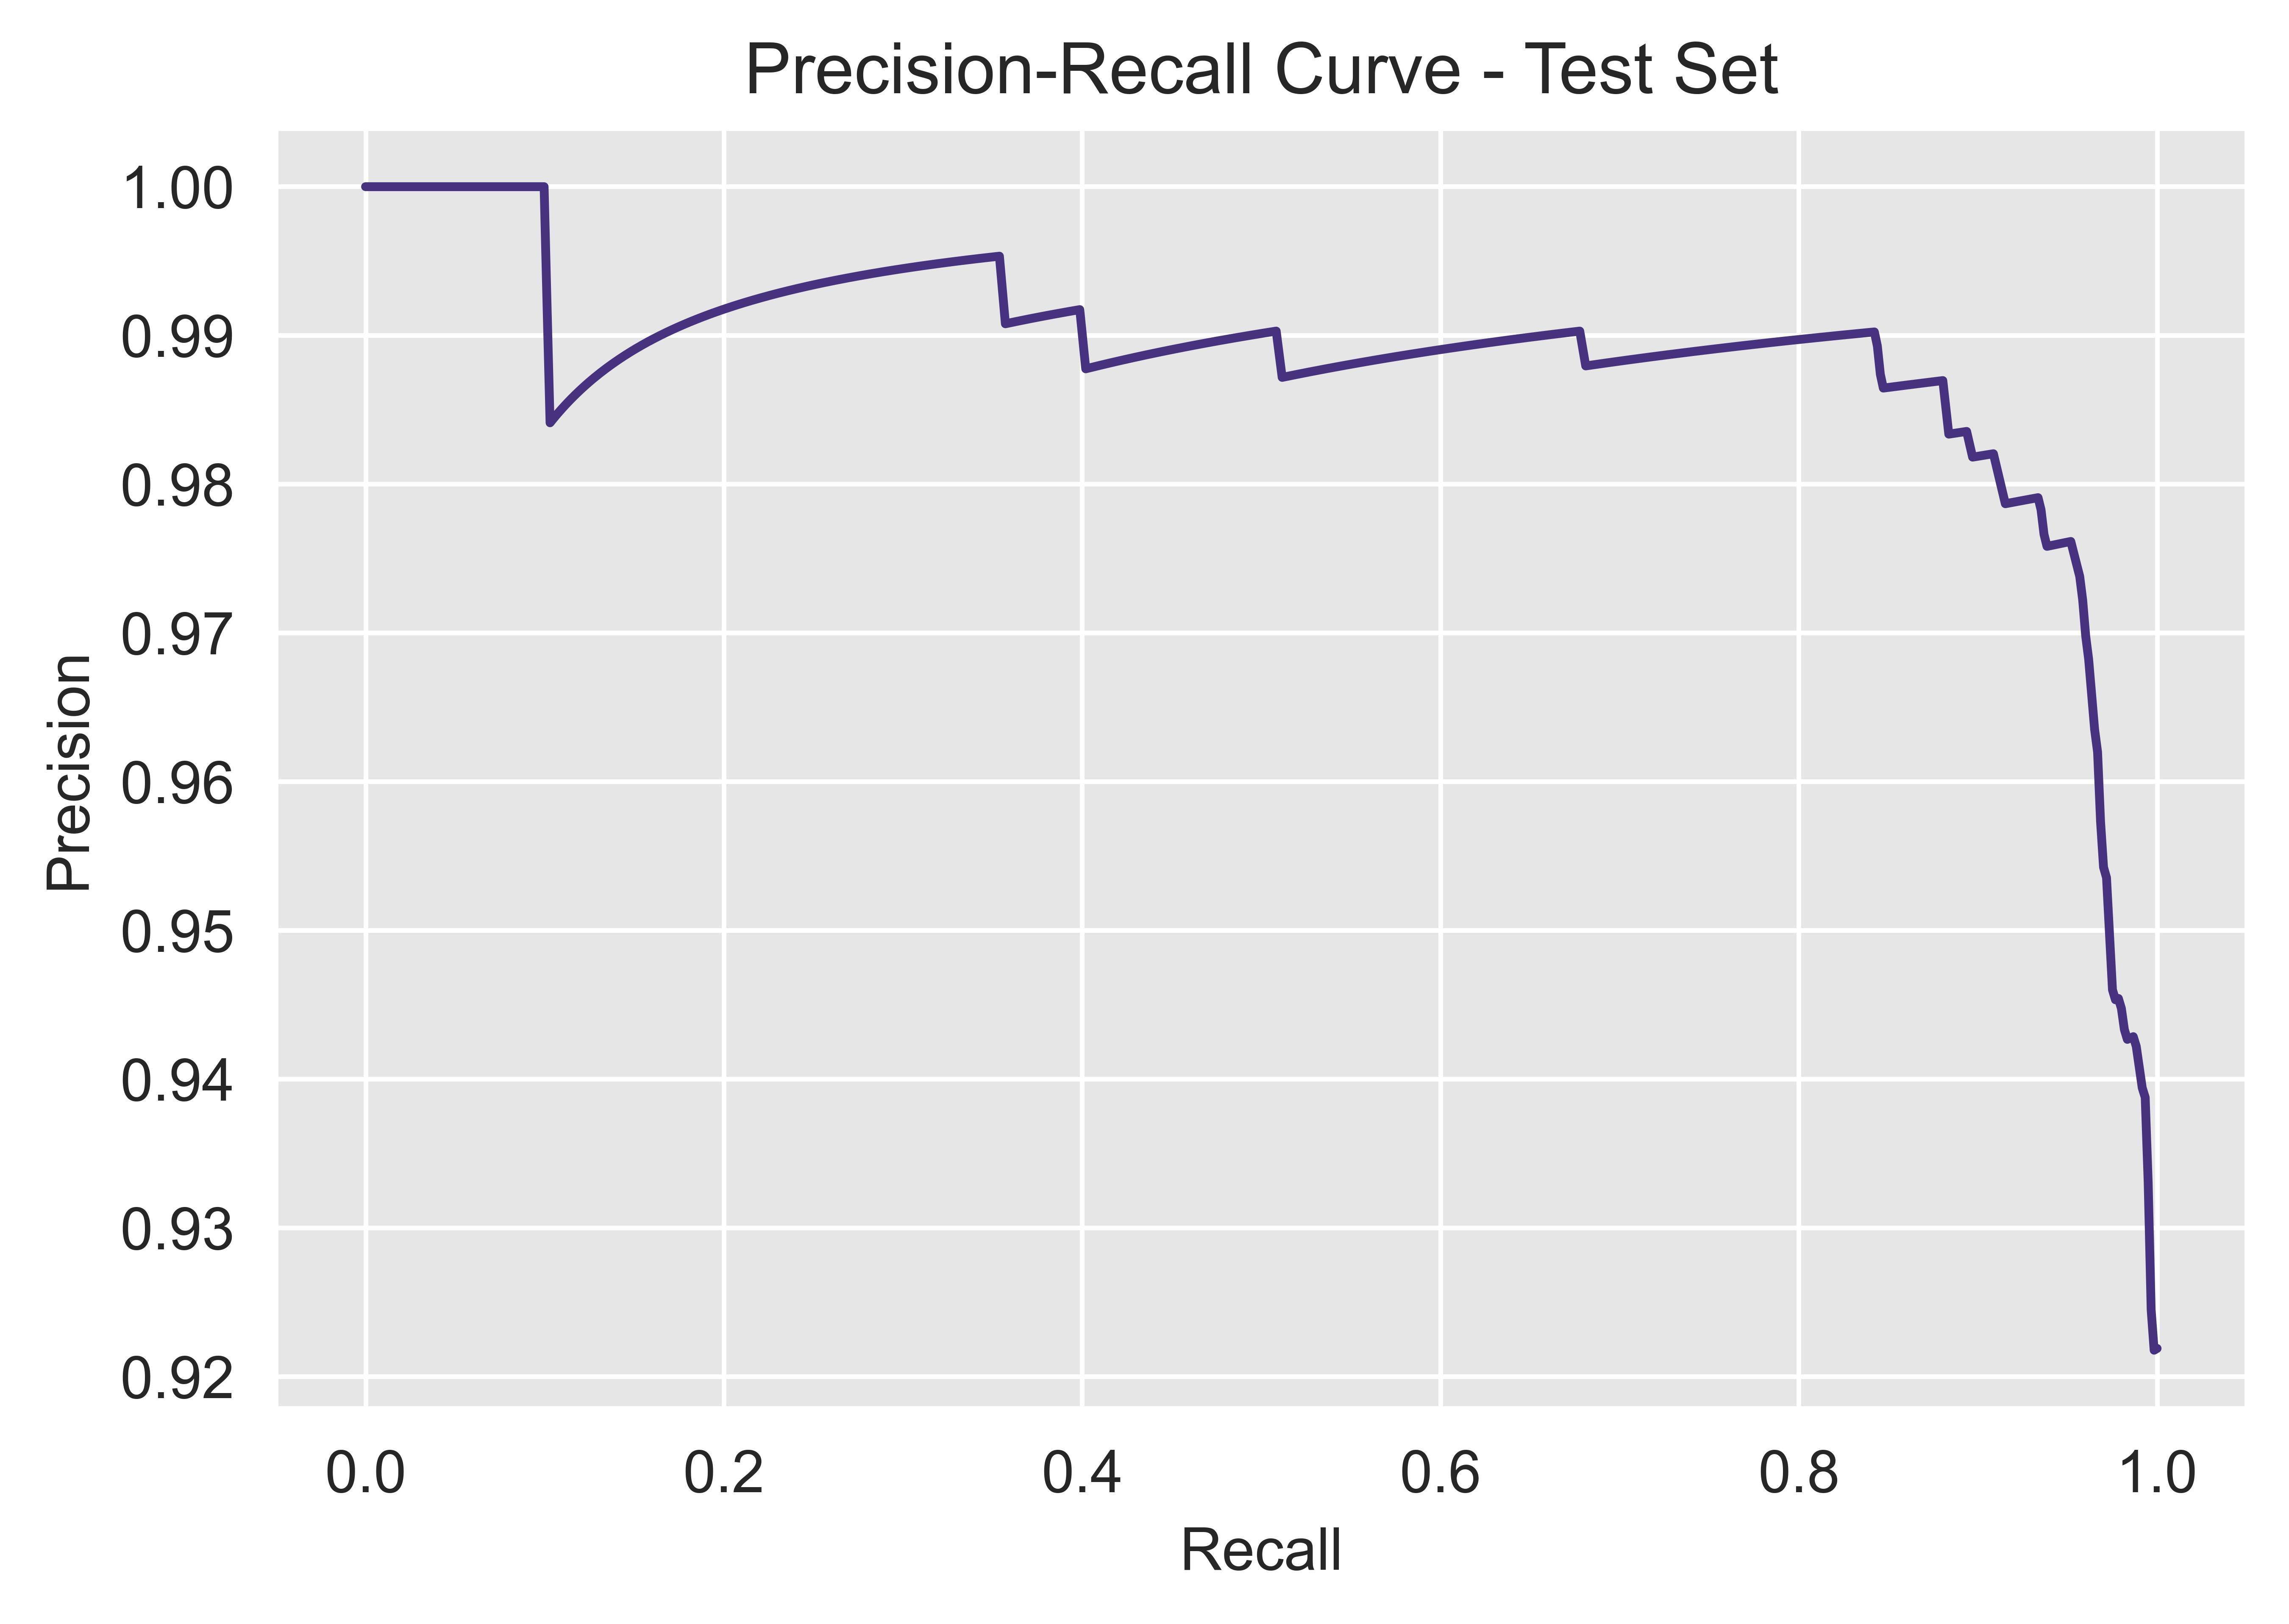

In [239]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')

## Perform machine learning while searching for best hyperparameters with KNN Model

### KNN Distance

In [240]:
# Tune hyperparameters

ks = [1, 5, 10, 20, 50, 100, 500, 1000, 5000] # Coarse hyperparameter search

roc_auc_val_list = []

for k in ks:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = KNeighbors_classifier(k, X_train, y_train, X_val, y_val, X_test, y_test, print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [241]:
roc_auc_val_df = pd.DataFrame({'K':ks, 'AUROC':roc_auc_val_list})
best_k = ks[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['K'] == best_k])

K     AUROC
0     1  0.570942
1     5  0.710180
2    10  0.762275
3    20  0.791983
4    50  0.810195
5   100  0.803993
6   500  0.741582
7  1000  0.730843
8  5000  0.757193

K     AUROC
4  50  0.810195

## Perform fine search for best hyperparameter based on initial coarse search

In [242]:
# Tune hyperparameters

ks = range(20, 520, 20) # Fine hyperparameter search

roc_auc_val_list = []

for k in ks:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = KNeighbors_classifier(k, X_train, y_train, X_val, y_val, X_test, y_test, print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [243]:
roc_auc_val_df = pd.DataFrame({'K':ks, 'AUROC':roc_auc_val_list})
best_k = ks[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['K'] == best_k])

K     AUROC
0    20  0.791983
1    40  0.807185
2    60  0.810649
3    80  0.807261
4   100  0.803993
5   120  0.800756
6   140  0.796975
7   160  0.790107
8   180  0.787838
9   200  0.790198
10  220  0.789805
11  240  0.783331
12  260  0.778944
13  280  0.774588
14  300  0.768507
15  320  0.767478
16  340  0.763606
17  360  0.761488
18  380  0.758009
19  400  0.755650
20  420  0.752292
21  440  0.748147
22  460  0.746423
23  480  0.743670
24  500  0.741582

K     AUROC
2  60  0.810649

## Re-train with best K value

In [244]:
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = KNeighbors_classifier(best_k, X_train, y_train, X_val, y_val, X_test, y_test, print_out=False)

## Generate plots for analysis

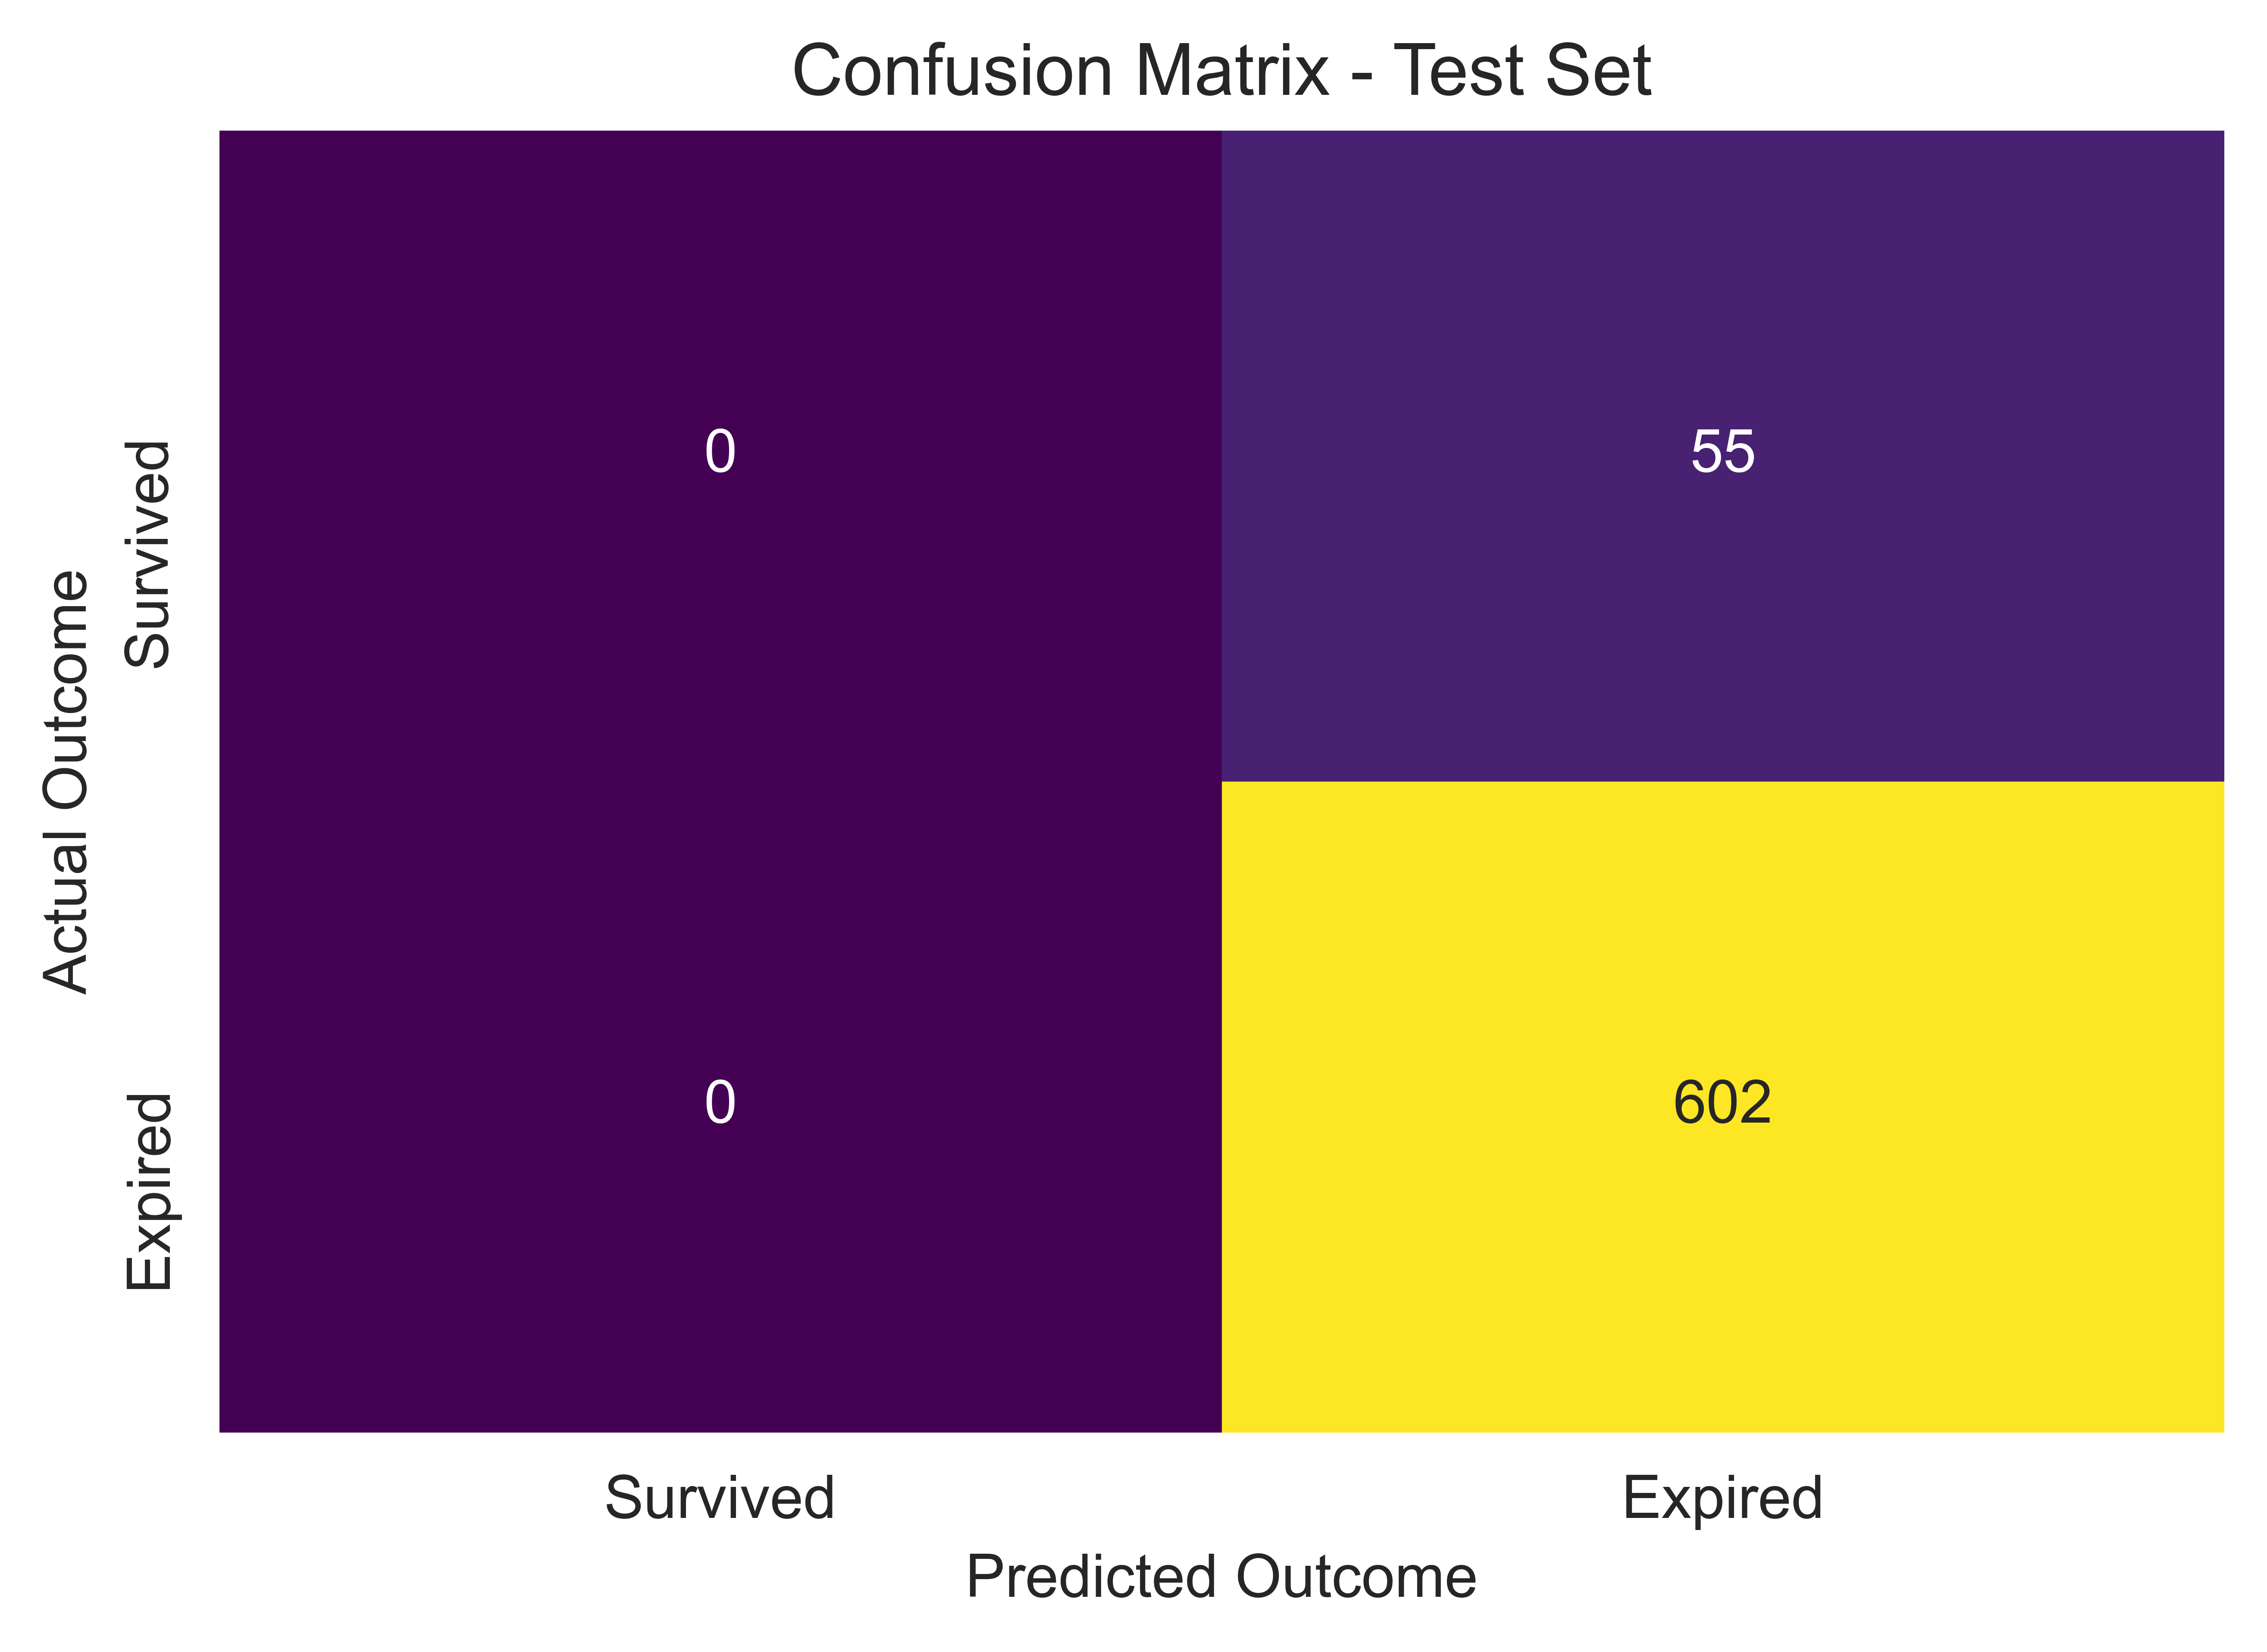

In [245]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

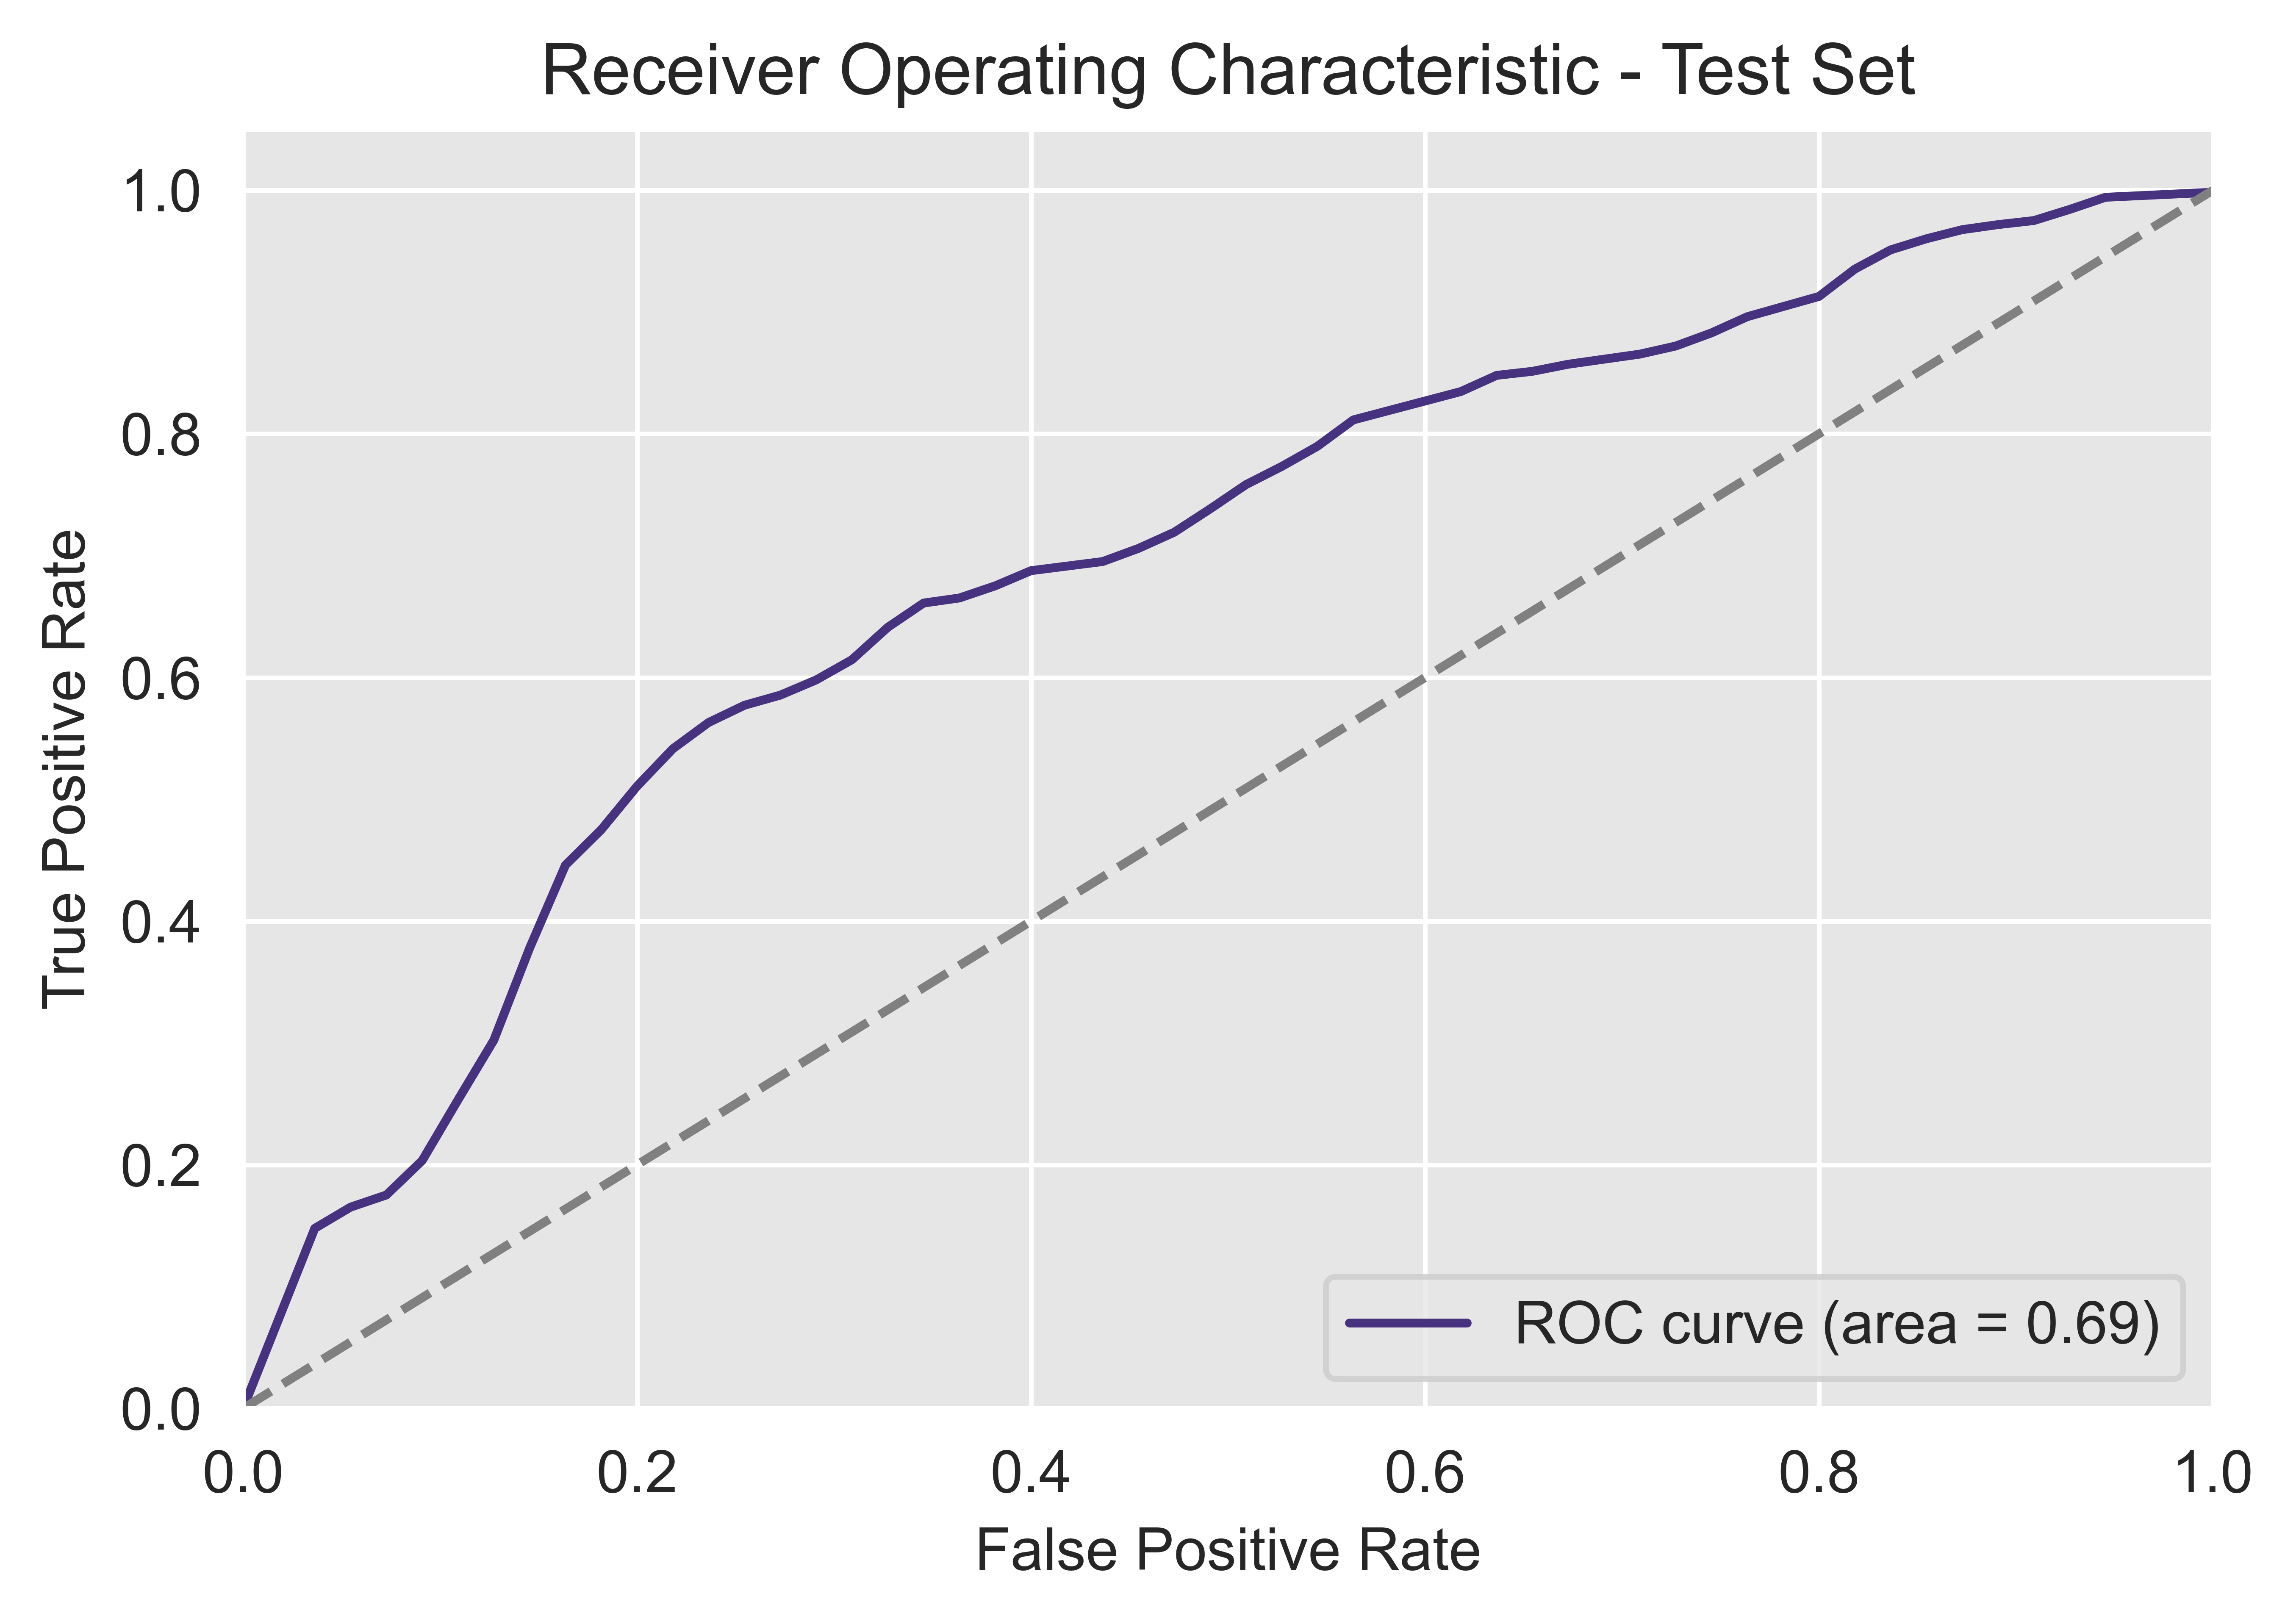

In [246]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_roc_curve(y_test, y_test_proba, 'Test Set')

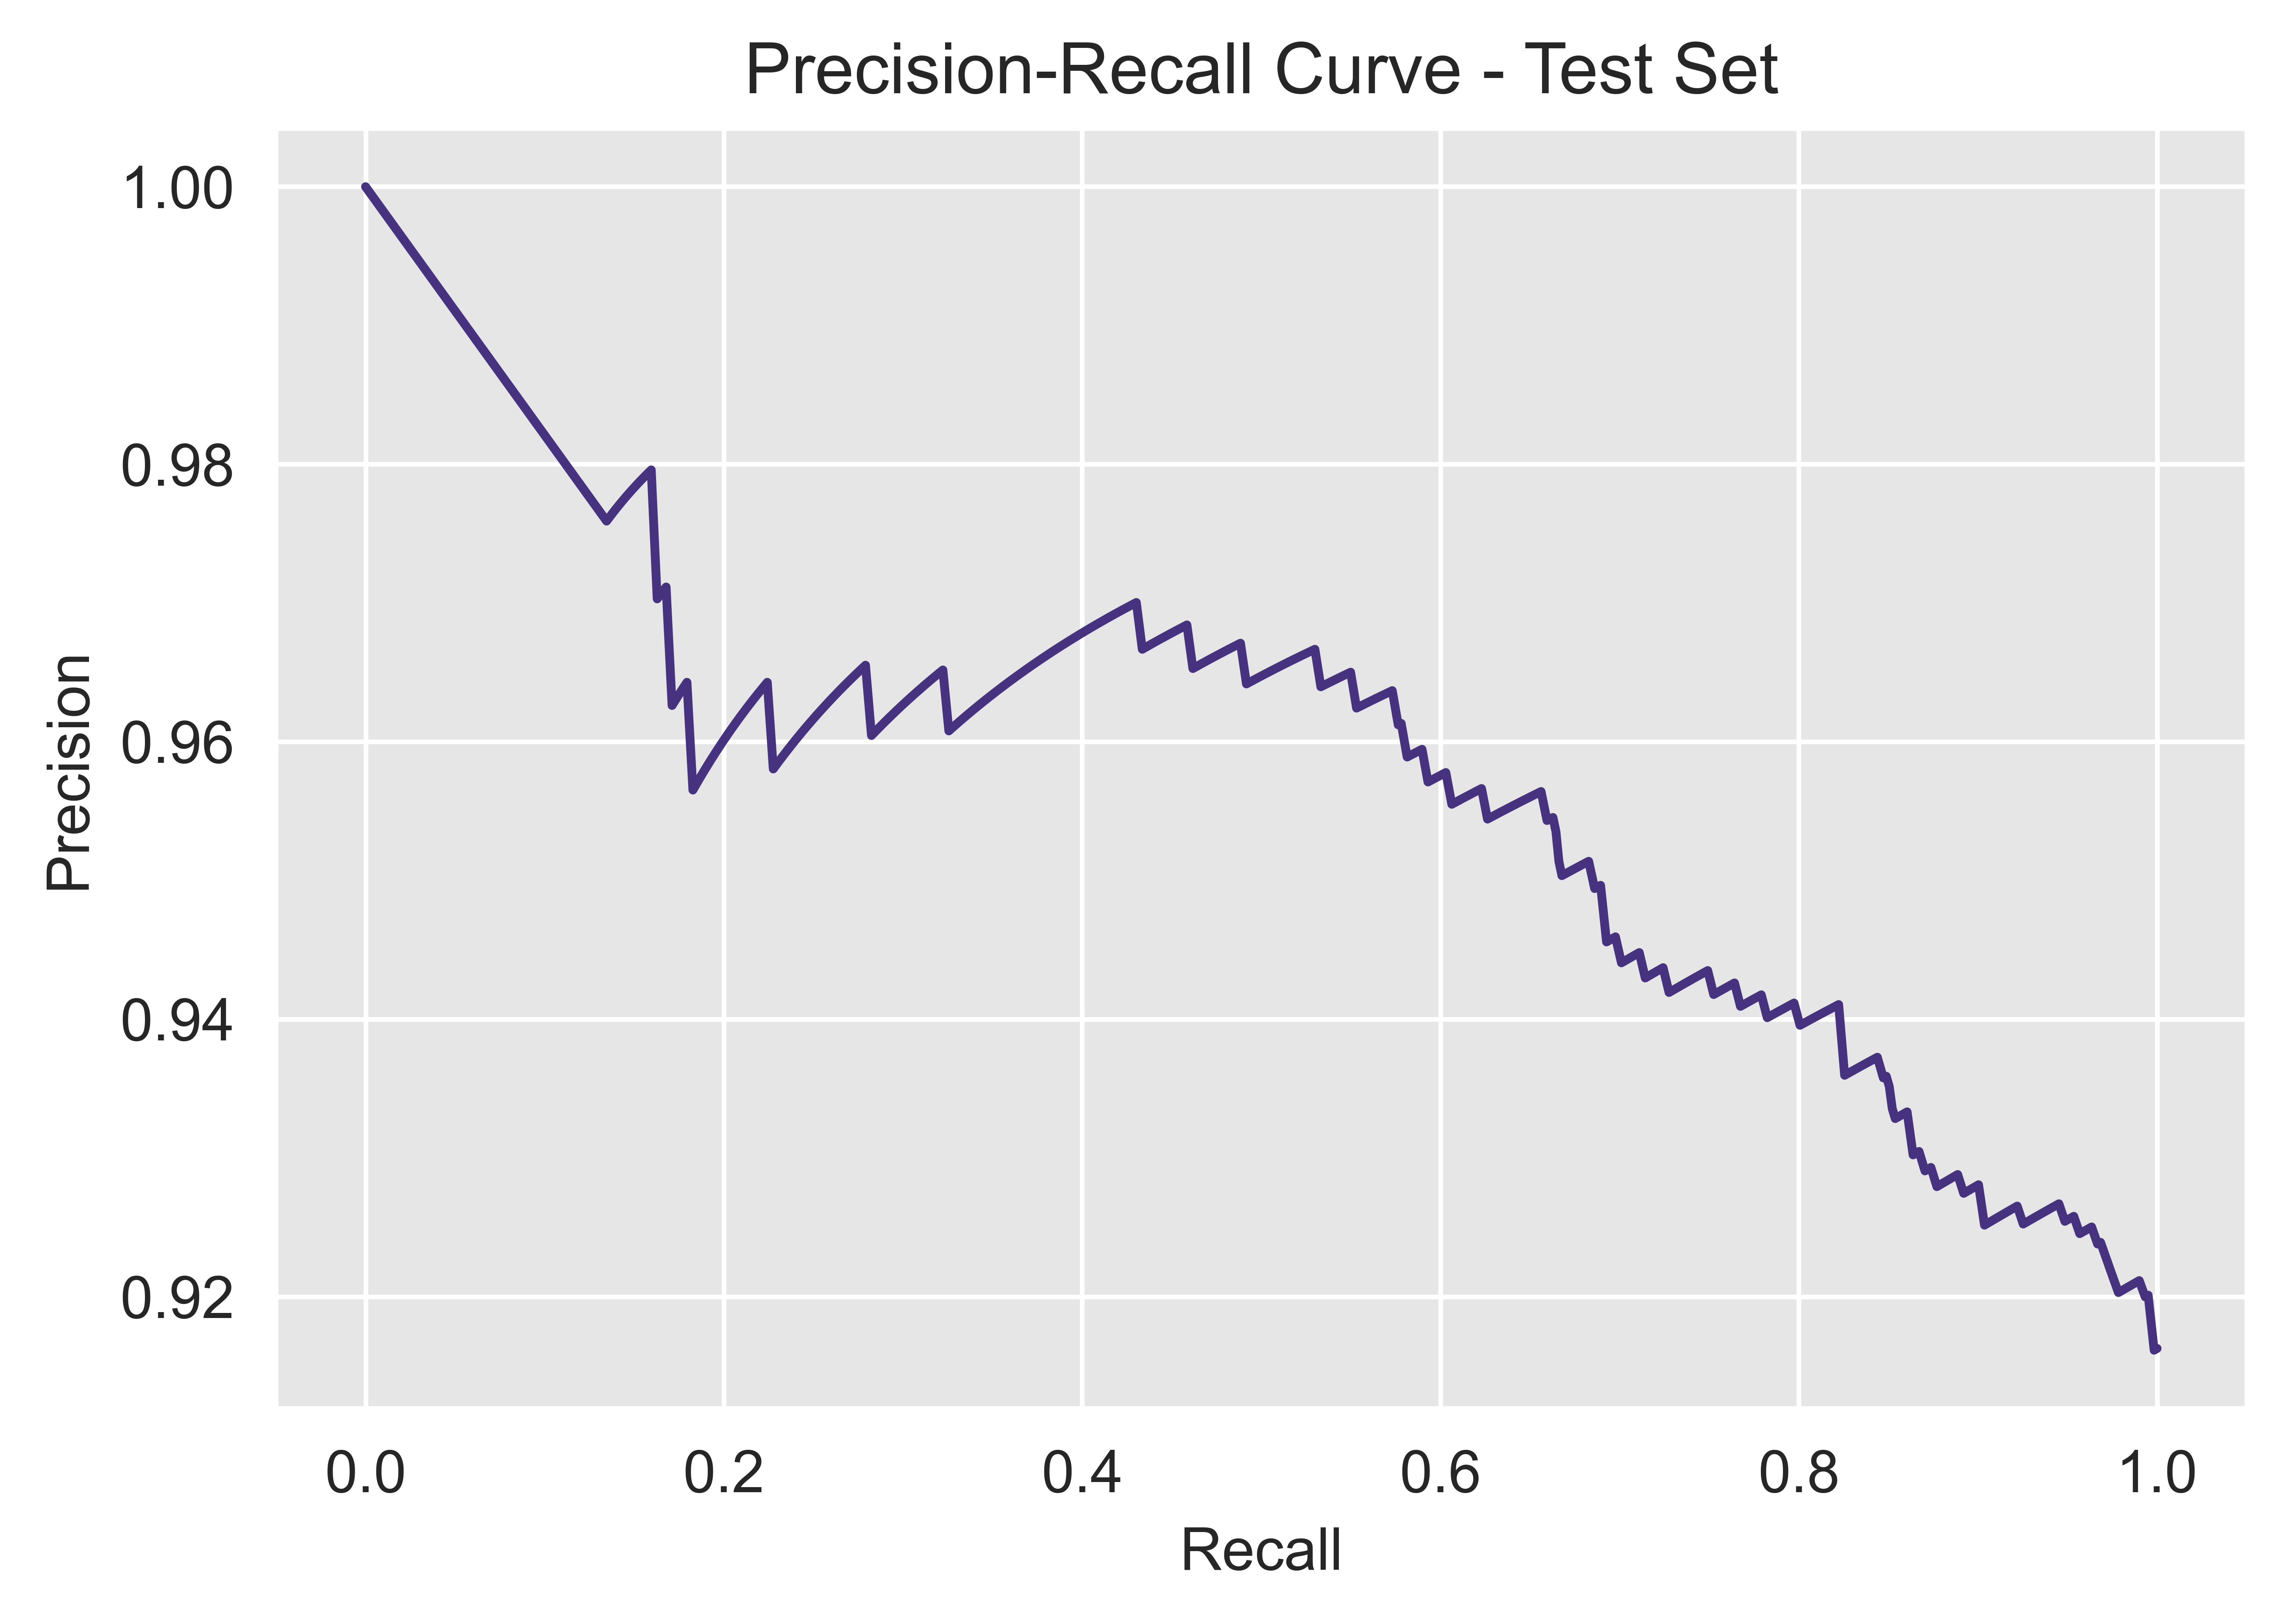

In [247]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')

# Let's try classifying using a subset of data available PTA/ On arrival

> This was performed using data fields that you would have available from the radio report/ initial set of vital signs from the patient (excluding `Pulse Oximetry`, limited sample pool too much)

> Only included cases that were labeled a `Thoracotomy` via the `HMRRHGCTRLSURGTYPE` data field, occurred within the first `20 minutes` on `Day 1` according to the `HMRRHGCTRLSURGMINS` and `HMRRHGCTRLSURGDAYS` data fields (*for some years only `HMRRHGCTRLSURGHRS` is available and so `HMRRHGCTRLSURGMINS` is derived by multiplying this by `60 minutes`*).

> Anybody who did not have a know `EDDISCHARGEDISPOSITION` **or** `HOSPDISCHARGEDISPOSITION` was excluded

In [257]:
TRAUMA_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLTRAUMA_df_%i.csv'
ICDPROCEDURE_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/MLICDPROCEDURE_df_%i.csv'

years = range(2017, 2023)

# Preload column names
TRAUMA_cols = pd.read_csv(TRAUMA_fp % 2017, nrows=1).columns.tolist()
ICDPROCEDURE_cols = pd.read_csv(ICDPROCEDURE_fp % 2017, nrows=1).columns.tolist()

# Collect DataFrames in lists
trauma_dfs = []
icdprocedure_dfs = []

for year in years:
    trauma_df = pd.read_csv(TRAUMA_fp % year, usecols=TRAUMA_cols)
    trauma_df['Year'] = year
    icdprocedure_df = pd.read_csv(ICDPROCEDURE_fp % year, usecols=ICDPROCEDURE_cols)
    icdprocedure_df['Year'] = year
    trauma_dfs.append(trauma_df)
    icdprocedure_dfs.append(icdprocedure_df)

# Concatenate DataFrames once at the end
TRAUMA_all_df = pd.concat(trauma_dfs, ignore_index=True)
ICDPROCEDURE_all_df = pd.concat(icdprocedure_dfs, ignore_index=True)

TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['HMRRHGCTRLSURGMINS'])
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['AGEYEARS'])
TRAUMA_all_df['HMRRHGCTRLSURGMINS'] = TRAUMA_all_df['HMRRHGCTRLSURGMINS'].round().astype(int)
TRAUMA_all_df = TRAUMA_all_df.loc[(TRAUMA_all_df['HMRRHGCTRLSURGMINS'] <= 20) & (TRAUMA_all_df['HMRRHGCTRLSURGDAYS'] <= 1.0)]
ICDPROCEDURE_all_df = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['INC_KEY'].isin(np.unique(TRAUMA_all_df['INC_KEY']))]

# Step 1: Drop rows that have NaN in both columns
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'], how='all')

# Step 2: Replace NaN values in one column with the value from the other column
TRAUMA_all_df['EDDISCHARGEDISPOSITION'] = TRAUMA_all_df['EDDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'])
TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'].combine_first(TRAUMA_all_df['EDDISCHARGEDISPOSITION'])

# Step 3: Create the 'DECEASED' column
TRAUMA_all_df['DECEASED'] = 0  # Initialize with 0 (Survived)
TRAUMA_all_df.loc[(TRAUMA_all_df['EDDISCHARGEDISPOSITION'] == 5.0) | 
                  (TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] == 5.0), 'DECEASED'] = 1

# Step 4: Drop the 'EDDISCHARGEDISPOSITION' and 'HOSPDISCHARGEDISPOSITION' columns
TRAUMA_all_df = TRAUMA_all_df.drop(columns=['EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION', 'INC_KEY'])

# Step 5: Select rows of interest
input_list = ['SEX', 'AGEYEARS', 'TRANSPORTMODE', 'EMSSBP', 'EMSPULSERATE', 'EMSRESPIRATORYRATE', 
              'EMSTOTALGCS', 'PREHOSPITALCARDIACARREST', 'SBP', 'PULSERATE', 
              'RESPIRATORYRATE', 'TOTALGCS', 'HOSPITALTYPE', 'TRAUMATYPE', 'MECHANISM', 'TCCSBPLT30',
              'TCCGCSLE13', 'TCC10RR29', 'TCCPEN', 'TCCCHEST', 'TCCLONGBONE', 'TCCCRUSHED', 'TCCAMPUTATION',
              'TCCPELVIC', 'TCCSKULLFRACTURE', 'TCCPARALYSIS'
             ]
required_list = ['DECEASED']
TRAUMA_all_df = TRAUMA_all_df.loc[:, input_list + required_list]

TRAUMA_all_df = TRAUMA_all_df.dropna(subset=input_list, how='any')

# Step 8: Remove columns ending in _BIU
TRAUMA_all_df = TRAUMA_all_df.drop(TRAUMA_all_df.filter(regex='_BIU$').columns, axis=1)

# Step 9: Convert strings to numbers

# Identify columns with string values
string_columns = TRAUMA_all_df.select_dtypes(include='object').columns

# Initialize a dictionary to store mapping dictionaries
mapping_dicts = {}

# Convert each unique string to an integer and create mapping dictionaries
for col in string_columns:
    unique_strings = TRAUMA_all_df[col].unique()
    string_to_int = {string: idx for idx, string in enumerate(unique_strings)}
    int_to_string = {idx: string for string, idx in string_to_int.items()}
    
    # Store the mapping dictionaries
    mapping_dicts[col] = {
        'string_to_int': string_to_int,
        'int_to_string': int_to_string
    }
    
    # Map the strings to integers in the DataFrame
    TRAUMA_all_df[col] = TRAUMA_all_df[col].map(string_to_int)

# Display results
display(TRAUMA_all_df.tail())
print(np.shape(TRAUMA_all_df))
display(ICDPROCEDURE_all_df.tail())
print(np.shape(ICDPROCEDURE_all_df))

# Free up memory
del trauma_dfs, icdprocedure_dfs

SEX  AGEYEARS  TRANSPORTMODE  EMSSBP  EMSPULSERATE  EMSRESPIRATORYRATE  \
10769  2.0      30.0            1.0     0.0           0.0                 0.0   
10773  2.0      76.0            1.0   104.0          77.0                18.0   
10774  2.0      30.0            1.0   146.0         109.0                 0.0   
10781  1.0      20.0            1.0     0.0           0.0                 0.0   
10784  1.0      30.0            1.0   138.0         112.0                10.0   

       EMSTOTALGCS  PREHOSPITALCARDIACARREST    SBP  PULSERATE  ...  \
10769          3.0                       1.0    0.0        0.0  ...   
10773          3.0                       2.0  104.0       89.0  ...   
10774          3.0                       1.0    0.0        0.0  ...   
10781          3.0                       1.0    0.0        0.0  ...   
10784          8.0                       2.0  133.0       53.0  ...   

       TCC10RR29  TCCPEN  TCCCHEST  TCCLONGBONE  TCCCRUSHED  TCCAMPUTATION  \
10769        0.0     1.0       0.0          0.0         0.0            0.0   
10773        0.0     0.0       0.0          0.0         0.0            0.0   
10774        0.0     0.0       0.0          0.0         0.0            0.0   
10781        0.0     1.0       0.0          0.0         0.0            0.0   
10784        0.0     0.0       0.0          0.0         0.0            0.0   

       TCCPELVIC  TCCSKULLFRACTURE  TCCPARALYSIS  DECEASED  
10769        0.0               0.0           0.0         1  
10773        0.0               0.0           0.0         1  
10774        0.0               0.0           0.0         1  
10781        0.0               0.0           0.0         1  
10784        0.0               0.0           0.0         1  

[5 rows x 27 columns]

(1784, 27)


INC_KEY ICDPROCEDURECODE  PROCEDUREMINS  PROCEDUREDAYS  Year
274140  220072330368          30233N1            7.2            1.0  2022
274141  220072330368          3E080GC            0.0            1.0  2022
274142  220072330368          5A12012            0.0            1.0  2022
274143  220072330368          5A1935Z            3.0            1.0  2022
274144  220072330368          BW40ZZZ            0.0            1.0  2022

(103042, 5)


## Create data splits

In [258]:
X_train, y_train, X_val, y_val, X_test, y_test = make_splits(TRAUMA_all_df, y_column='DECEASED')

## Perform machine learning while searching for best hyperparameters with Logistic Regression Model Using L2 penalty (LASSO)

In [259]:
# Tune hyperparameters

alphas = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001] # Coarse hyperparameter search

roc_auc_val_list = []

for alpha in alphas:
    model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(alpha, X_train, y_train, X_val, y_val, X_test, y_test, penalty='l2', iterations=1000, print_out=False)
    roc_auc_val_list.append(roc_auc_val)

### Best hyperparameter and AUROC

In [260]:
roc_auc_val_df = pd.DataFrame({'Alpha':alphas, 'AUROC':roc_auc_val_list})
best_alpha = alphas[roc_auc_val_list.index(max(roc_auc_val_list))]
display(roc_auc_val_df)
display(roc_auc_val_df[roc_auc_val_df['Alpha'] == best_alpha])

Alpha     AUROC
0  1.00000  0.882639
1  0.10000  0.876736
2  0.01000  0.863194
3  0.00100  0.848611
4  0.00010  0.849653
5  0.00001  0.847569

Alpha     AUROC
0    1.0  0.882639

## Re-train with best alpha value

In [261]:
model, y_train_pred, y_val_pred, y_test_pred, y_train_proba, y_val_proba, y_test_proba, roc_auc_val, roc_auc_test = lasso_classifier(best_alpha, X_train, y_train, X_val, y_val, X_test, y_test, iterations=1000, print_out=False)

## Generate plots for analysis

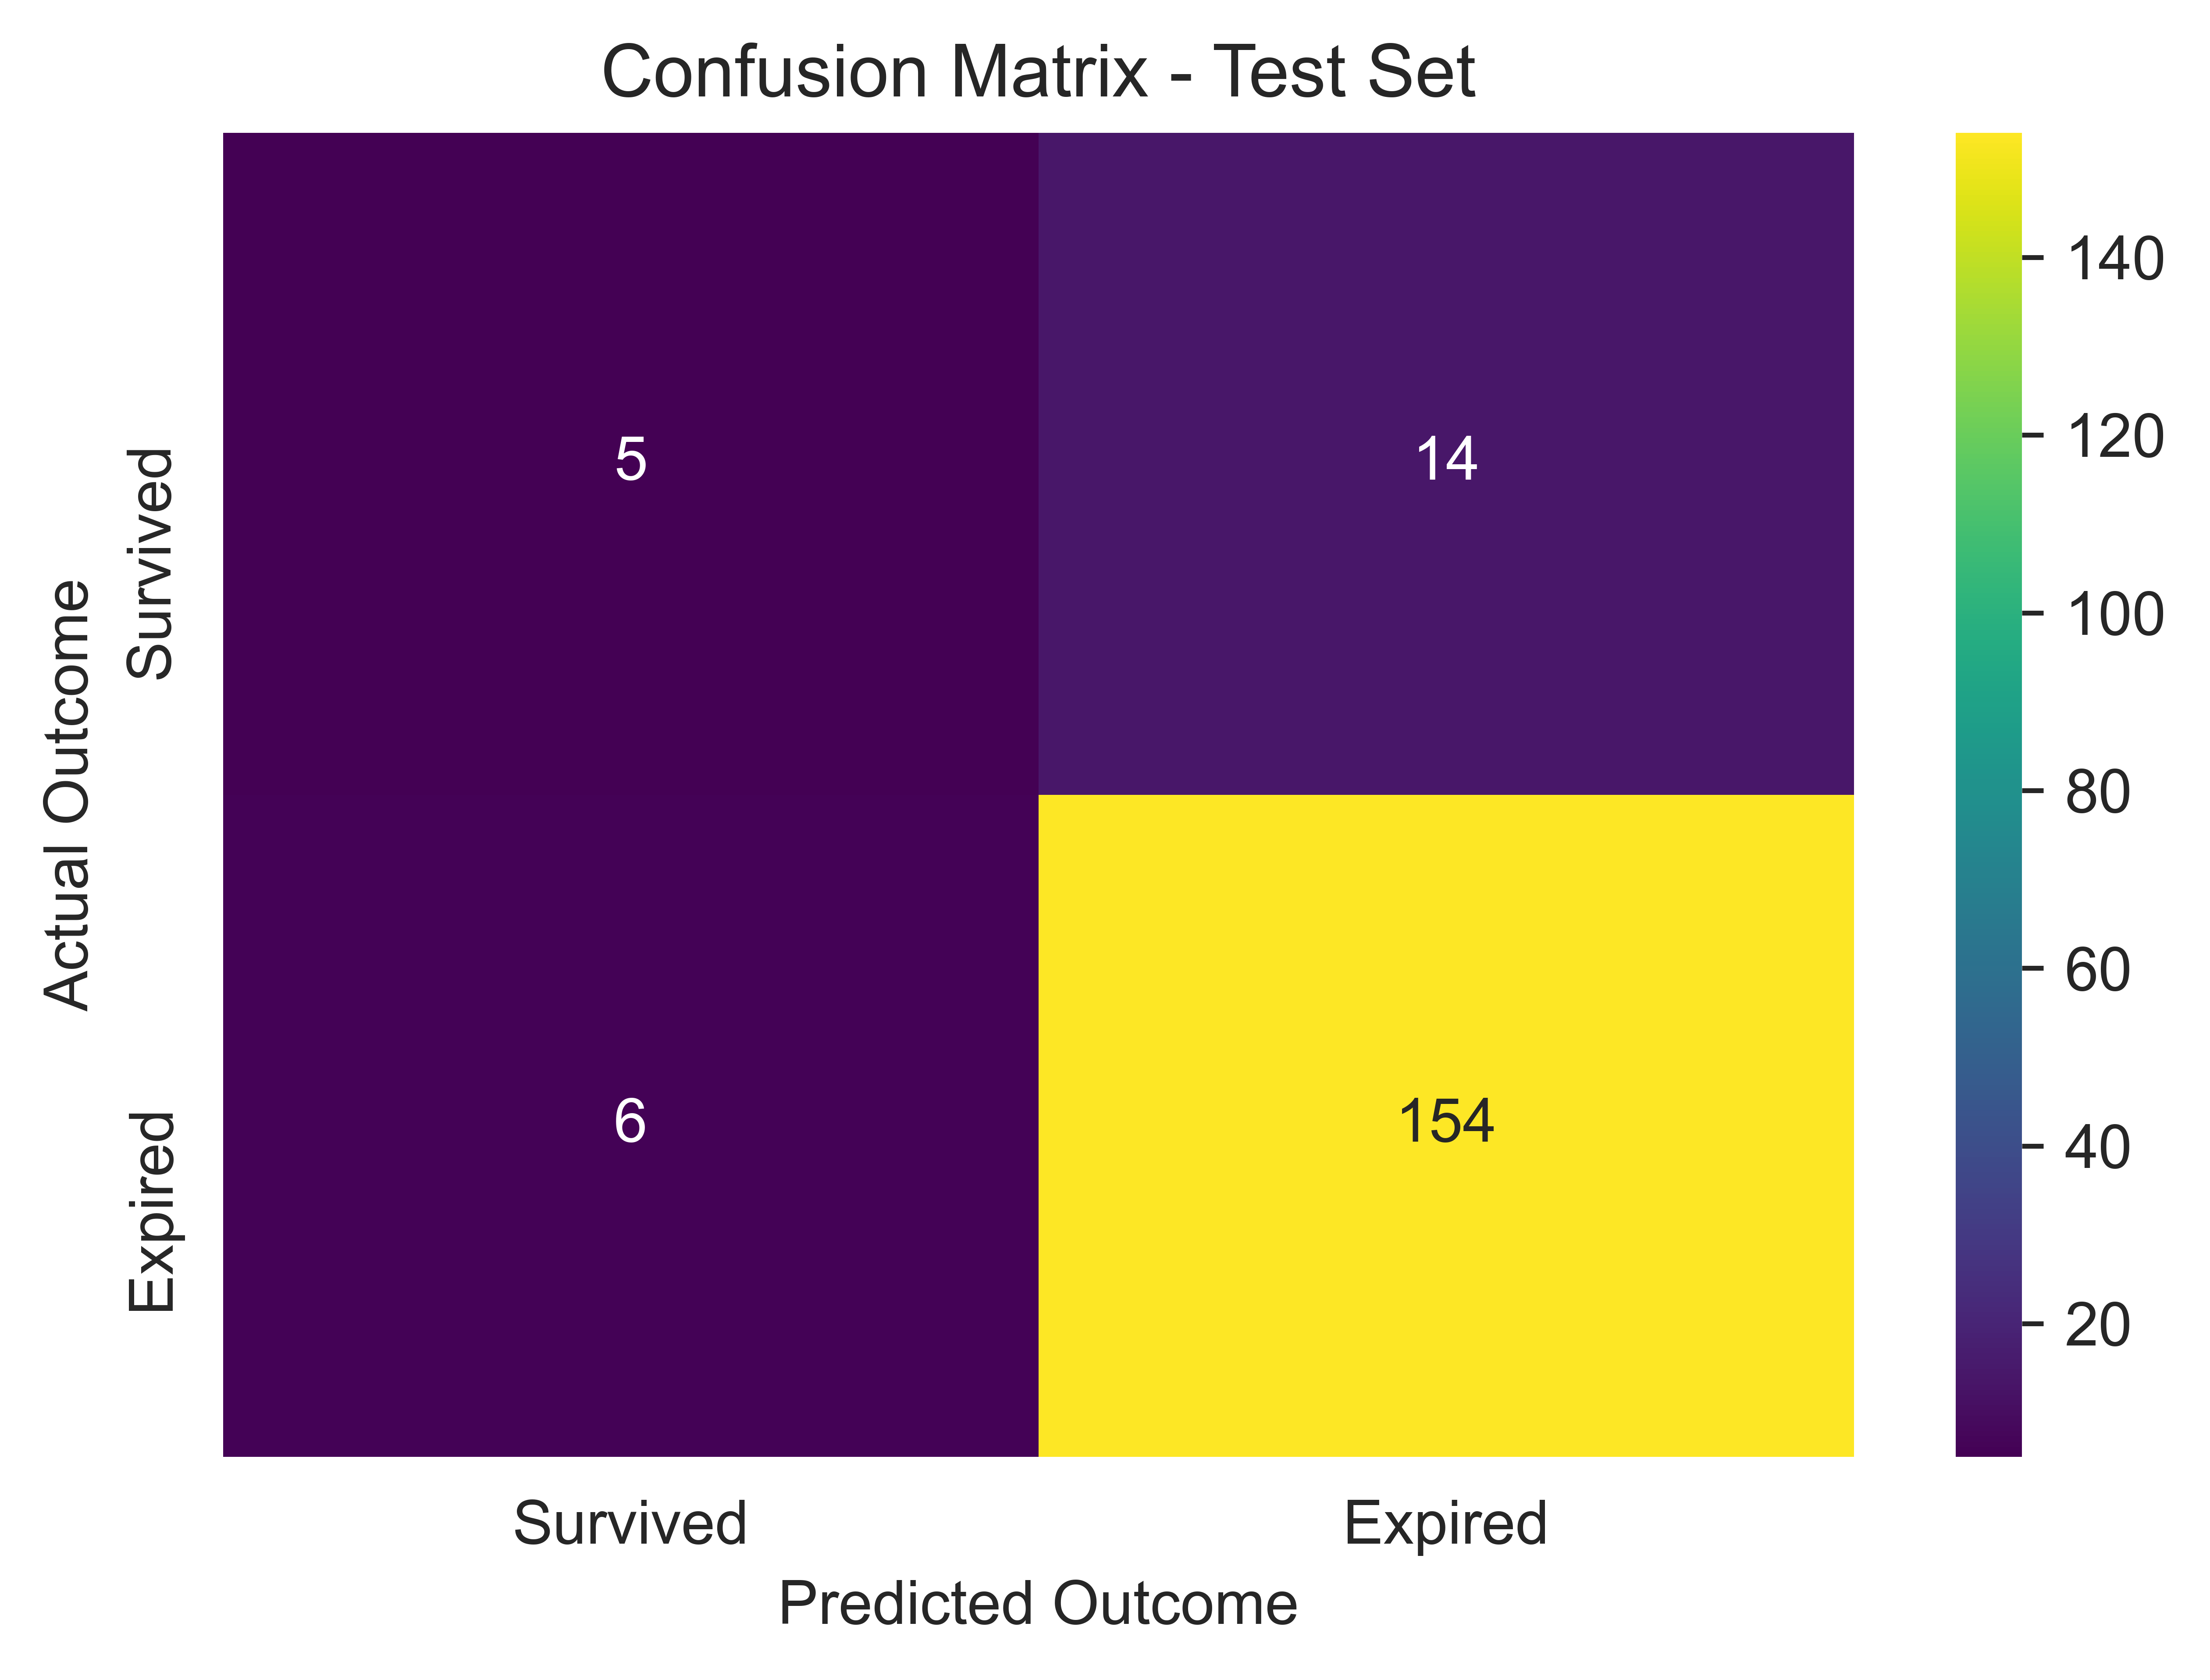

In [267]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

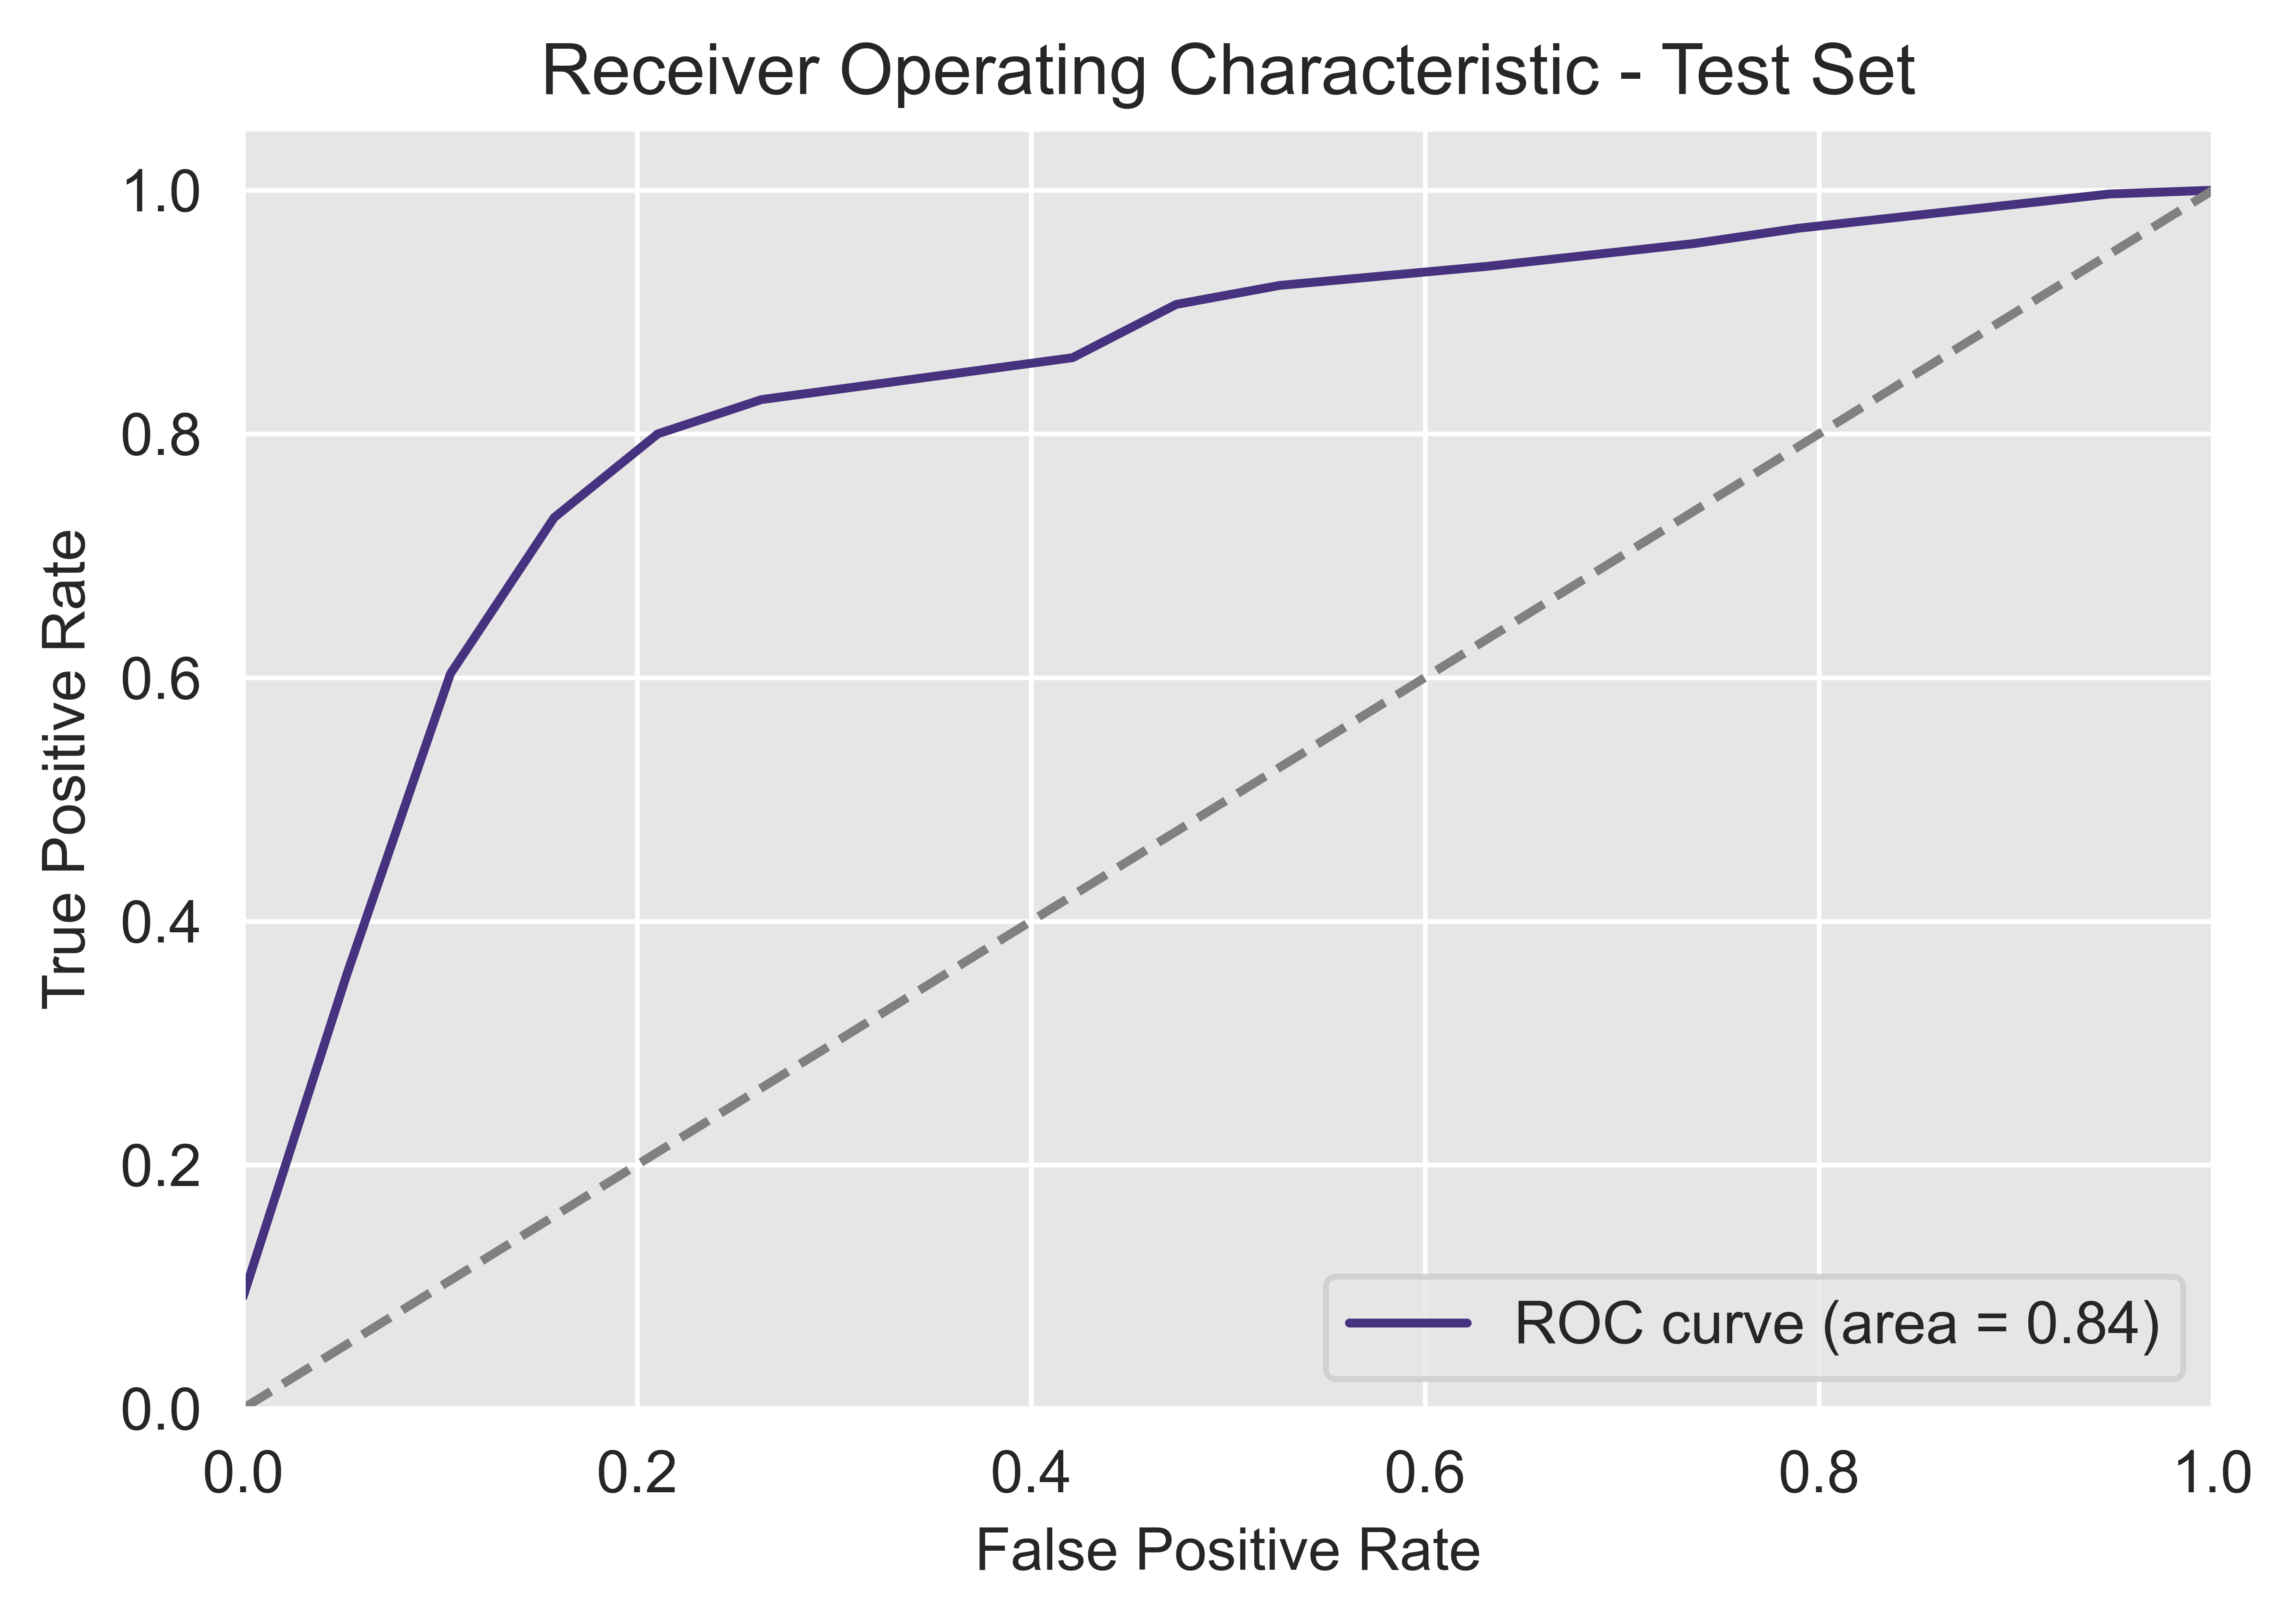

In [263]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_roc_curve(y_test, y_test_proba, 'Test Set')

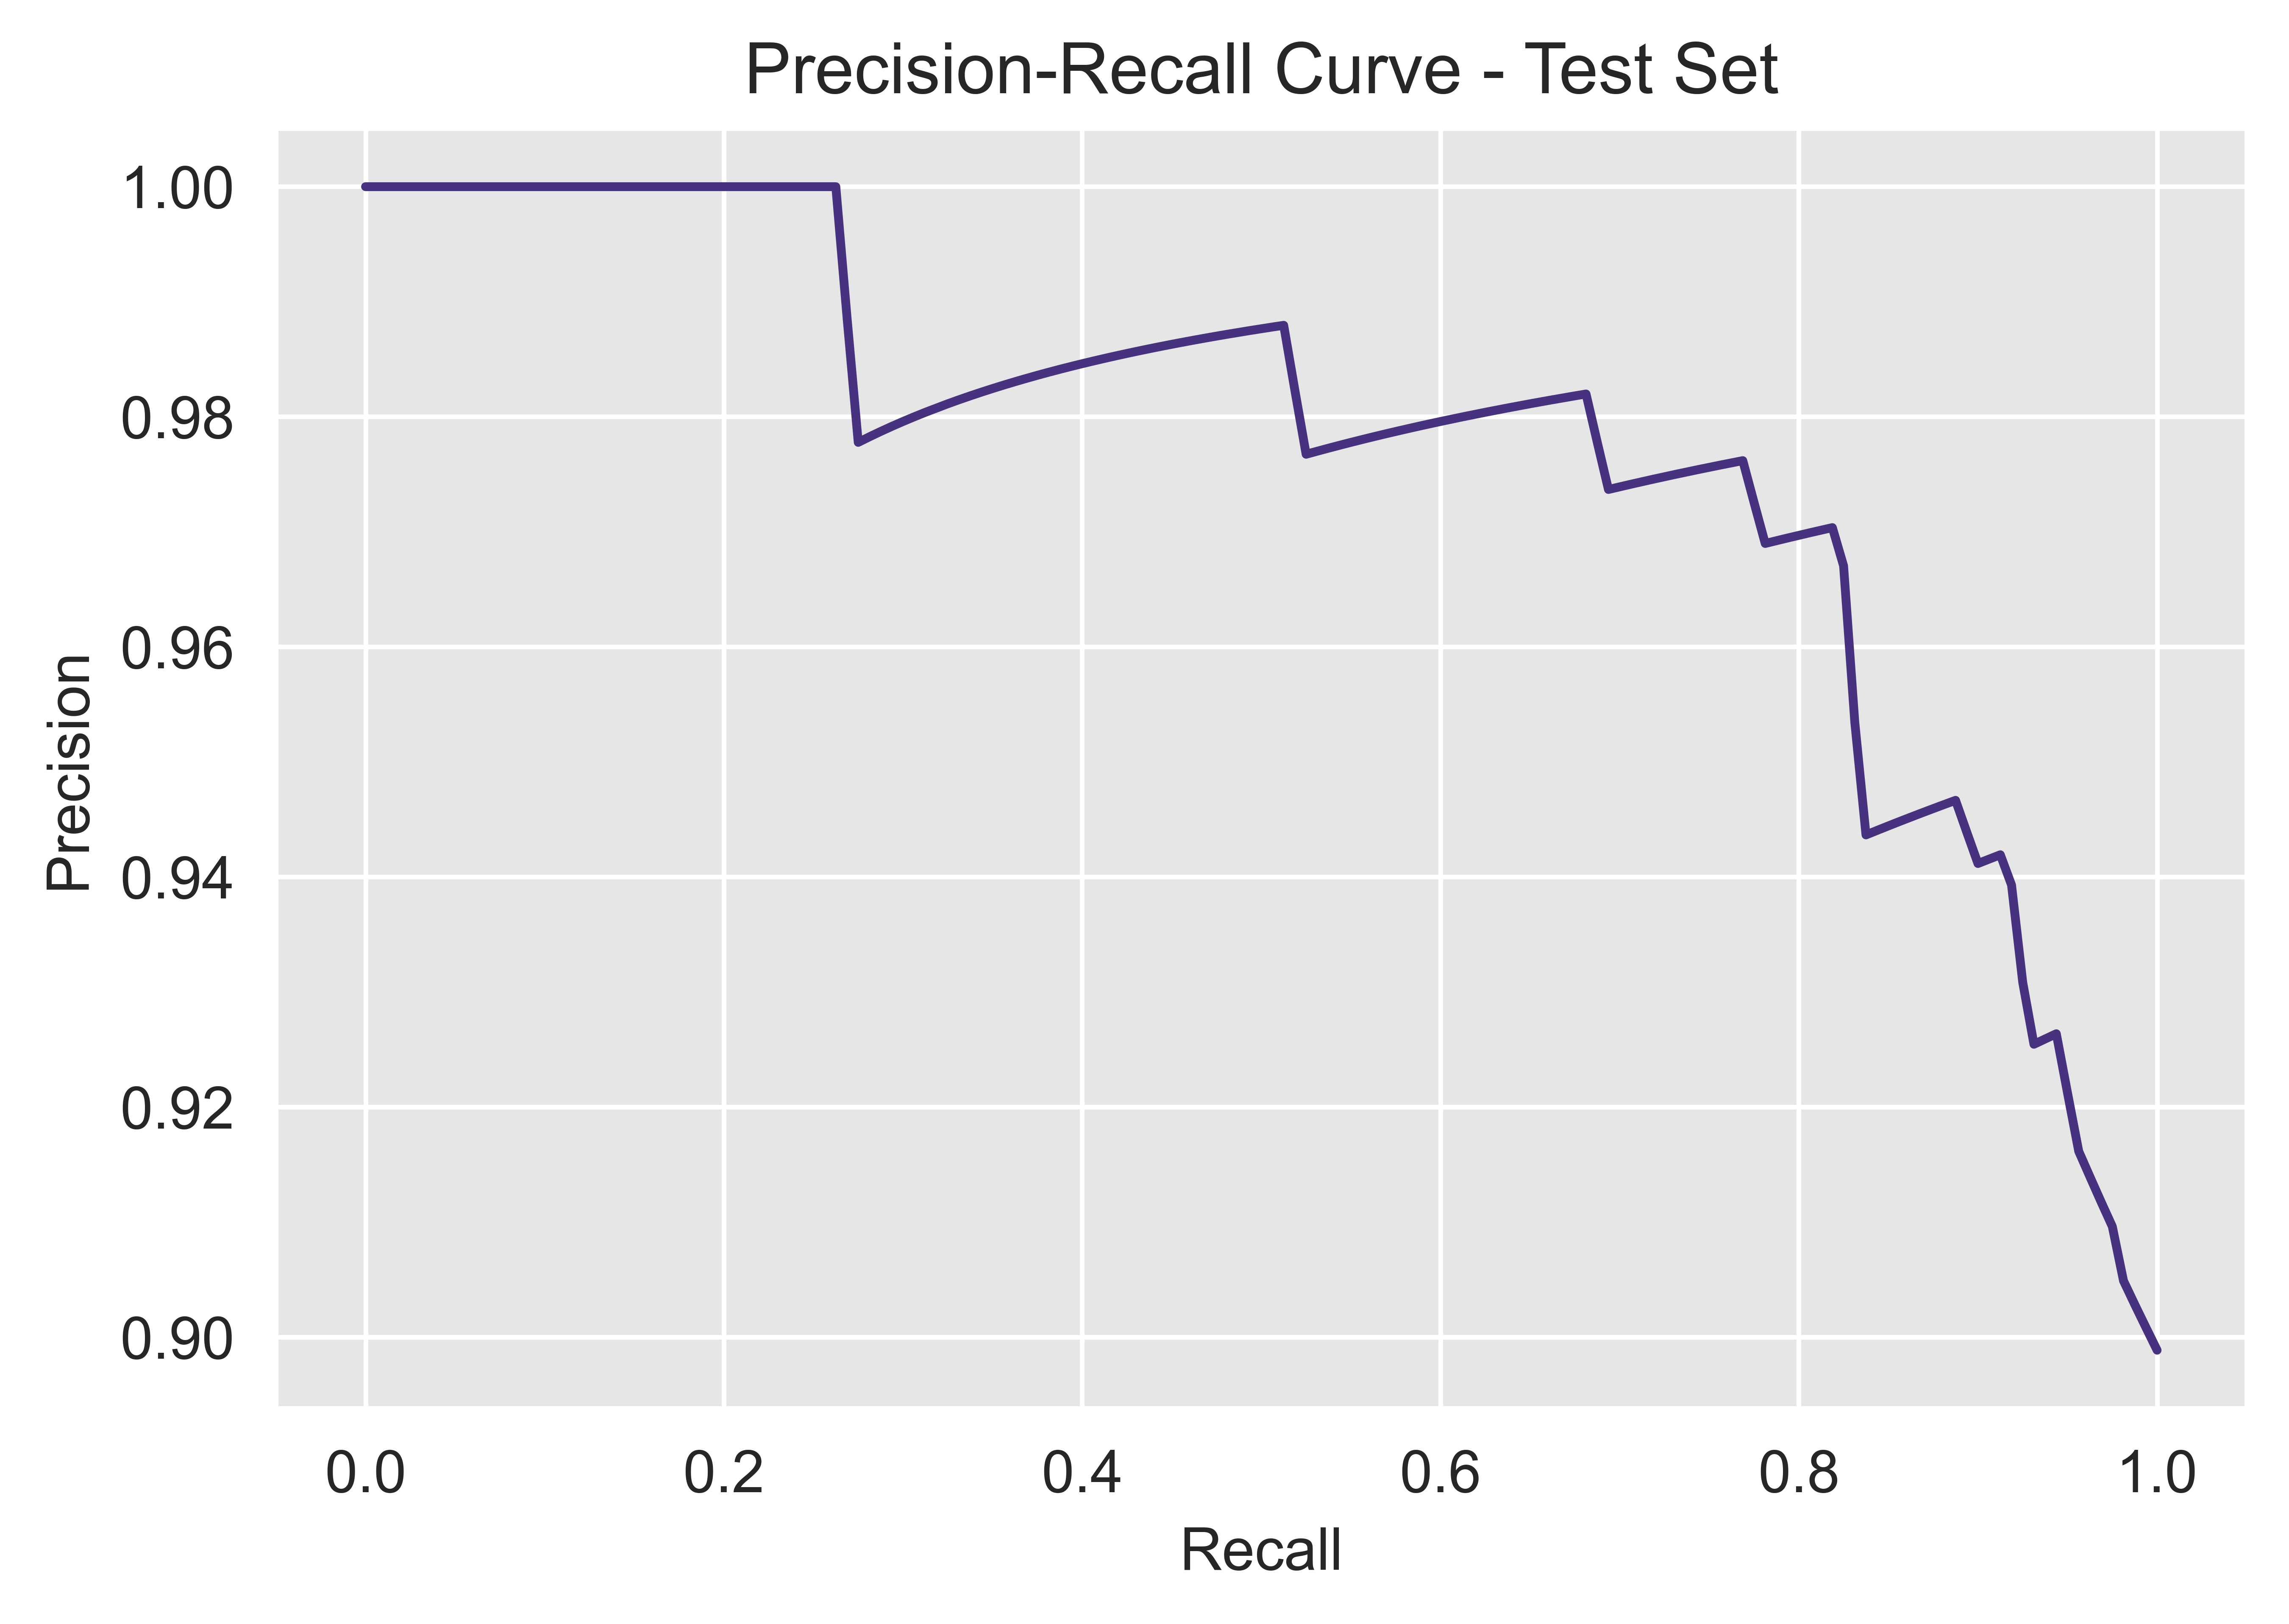

In [264]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)
plot_precision_recall_curve(y_test, y_test_proba, 'Test Set')